https://desi.lbl.gov/trac/wiki/MilkyWayWG/PipelineOutputs

https://desi.lbl.gov/trac/wiki/SurveyValidation/SV1

In [365]:
pwd

'/global/cfs/cdirs/desi/users/apcooper/projects/quicksv1'

In [247]:
import numpy as np
import glob
import os
import sys
import re
import subprocess
import fitsio
import healpy as hp
import warnings

from importlib import reload

from astropy.io import fits
from astropy.table import Table, Column
import astropy.coordinates as coords
import astropy.units as u

import matplotlib.pyplot as pl
%matplotlib inline

In [248]:
from desitarget.sv1.sv1_targetmask import desi_mask, mws_mask, bgs_mask

In [249]:
import desi_retriever
import desi_retriever.andes

In [605]:
import quicksv
reload(quicksv)
from quicksv import MWSExposures, MWSCoadd, plot_targetid, healpix_from_table, target_healpix_path, get_images

In [251]:
d = MWSExposures(redux='sv_daily',run=210110)
d

MWS: daily-exp-210110 (/global/cfs/cdirs/desi/science/mws/redux/sv_daily/rv_output/210110/rvtab_spectra-daily.fits)

The RV table is in d.rv and the 'fibermap' in d.fm (the fibermap columns can also be accessed directly throuhg d[]). If you don't want to use those objects just load the corresponding rv and fibermap tables and substitute below.

In [50]:
# Useful derived values

pm = np.sqrt(d['PMRA']**2 + d['PMDEC']**2)

gmag = 22.5 - 2.5 * np.log10(d['FLUX_G'].clip(1e-7))
rmag = 22.5 - 2.5 * np.log10(d['FLUX_R'].clip(1e-7))
zmag = 22.5 - 2.5 * np.log10(d['FLUX_Z'].clip(1e-7))

gmr = gmag - rmag
rmz = rmag - zmag

In [21]:
# Summary of target types
mws_class_tab = Table(np.unique(d['SV1_MWS_TARGET'],return_counts=True),names=[None,'Counts'])
col = Column([','.join(mws_mask.names(_)) if _ != 999999 else 'M31_M33' for _ in mws_class_tab['SV1_MWS_TARGET']],name='NAME')
mws_class_tab.add_column(col)
mws_class_tab

<Table length=11>
SV1_MWS_TARGET Counts                      NAME                     
    int64      int64                      str46                     
-------------- ------ ----------------------------------------------
             0 524734                                               
             4    241                                     MWS_NEARBY
            17 123481            MWS_MAIN_BROAD,MWS_MAIN_BROAD_NORTH
            21    155 MWS_MAIN_BROAD,MWS_NEARBY,MWS_MAIN_BROAD_NORTH
            33 139391            MWS_MAIN_BROAD,MWS_MAIN_BROAD_SOUTH
            37    215 MWS_MAIN_BROAD,MWS_NEARBY,MWS_MAIN_BROAD_SOUTH
         49152  10544            MWS_MAIN_FAINT,MWS_MAIN_FAINT_NORTH
         49156     89 MWS_NEARBY,MWS_MAIN_FAINT,MWS_MAIN_FAINT_NORTH
         81920  14656            MWS_MAIN_FAINT,MWS_MAIN_FAINT_SOUTH
         81924    114 MWS_NEARBY,MWS_MAIN_FAINT,MWS_MAIN_FAINT_SOUTH
        999999  13775                                        M31_M33

In [30]:
desi_class_tab = Table(np.unique(d['SV1_DESI_TARGET'],return_counts=True),names=[None,'Counts'])
col = Column([','.join(desi_mask.names(_)) for _ in desi_class_tab['SV1_DESI_TARGET']],name='NAME')
desi_class_tab.add_column(col)
desi_class_tab

<Table length=371>
  SV1_DESI_TARGET   ...
       int64        ...
------------------- ...
                  0 ...
             999999 ...
            1048609 ...
            1310761 ...
            2097217 ...
            2621521 ...
            3145825 ...
            3407977 ...
            3670129 ...
            3932281 ...
                ... ...
2359890327910797062 ...
2485986994308677636 ...
3458764513820540928 ...
3458764531000410112 ...
3458768911867056132 ...
3458799698192662532 ...
3458817290378723332 ...
3468053188052004868 ...
3468053188135891029 ...
3512807709349036036 ...

#### Standards

In [158]:
is_std = ((d['SV1_DESI_TARGET'] & desi_mask['STD_BRIGHT']) != 0) | \
    ((d['SV1_DESI_TARGET'] & desi_mask['STD_FAINT']) != 0) | \
    ((d['SV1_DESI_TARGET'] & desi_mask['STD_WD']) != 0)
is_std.sum()

93592

In [165]:
# Some standards are  MWS targets
mws_stds = is_std & (d['SV1_MWS_TARGET'] > 0)
mws_stds.sum()

83101

In [166]:
# Some standards are not MWS targets
not_mws_stds = is_std & (d['SV1_MWS_TARGET'] == 0)
not_mws_stds.sum()

10491

#### MWS Targets

In [386]:
mws_sv_target = (d['SV1_MWS_TARGET'] > 0) & (d['SV1_MWS_TARGET'] != 999999)
m31_target = d['SV1_MWS_TARGET'] == 999999

In [383]:
def spec_ok(rv,success='SUCCESS'):
    return (rv[success]) & (rv['SN_B'] > 2) & (rv['SN_R'] > 2) & (rv['SN_Z'] > 2)  & (rv['RVS_WARN'] == 0)

def mws_samples(d):
    """
    """
    pm = np.sqrt(d['PMRA']**2 + d['PMDEC']**2)

    gmag = 22.5 - 2.5 * np.log10(d['FLUX_G'].clip(1e-7))
    rmag = 22.5 - 2.5 * np.log10(d['FLUX_R'].clip(1e-7))
    zmag = 22.5 - 2.5 * np.log10(d['FLUX_Z'].clip(1e-7))

    gmr = gmag - rmag
    rmz = rmag - zmag
    
    is_mws_red = (rmag < 19) & (pm < 7.0) & (np.isfinite(pm)) & (gmr > 0.7)
    is_mws_blue = (rmag < 19) & (gmr < 0.7)
    is_mws_broad = (rmag < 19) & ((pm >= 7.0) | (~np.isfinite(pm))) & (gmr > 0.7)
    
    return is_mws_red,is_mws_blue,is_mws_broad

In [368]:
def plot_compare_mws_samples(prop,d,bins,decorate=None,density=False,success='SUCCESS',sel=None):
    """
    """
    is_mws_red,is_mws_blue,is_mws_broad = mws_samples(d)
    
    mws_sv_target = (d['SV1_MWS_TARGET'] > 0) & (d['SV1_MWS_TARGET'] != 999999)

    specok = spec_ok(d.rv,success=success) 
    
    if sel is not None:
        specok &= sel

    h_red,_ = np.histogram(prop[is_mws_red & specok],bins=bins,density=density)
    h_blue,_ = np.histogram(prop[is_mws_blue & specok],bins=bins,density=density)
    h_broad,_ = np.histogram(prop[is_mws_broad & specok],bins=bins,density=density)

    h_red_mw,_ = np.histogram(prop[is_mws_red & specok & mws_sv_target],bins=bins,density=density)
    h_blue_mw,_ = np.histogram(prop[is_mws_blue & specok & mws_sv_target],bins=bins,density=density)
    h_broad_mw,_ = np.histogram(prop[is_mws_broad & specok & mws_sv_target],bins=bins,density=density)
    
    pl.figure(figsize=(12,6))

    pl.subplot(121)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pl.plot(bins[:-1],np.log10(h_red),drawstyle='steps-post',c='r',label='RED (all)')
        pl.plot(bins[:-1],np.log10(h_blue),drawstyle='steps-post',c='b',label='BLUE (all)')
        pl.plot(bins[:-1],np.log10(h_broad),drawstyle='steps-post',c='g',label='BROAD (all)')

    if decorate is not None:
        decorate()
    pl.title('All r < 19')
    
    pl.subplot(122)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pl.plot(bins[:-1],np.log10(h_red_mw),drawstyle='steps-post',c='r',label='SV1 MWS targets')
        pl.plot(bins[:-1],np.log10(h_blue_mw),drawstyle='steps-post',c='b')
        pl.plot(bins[:-1],np.log10(h_broad_mw),drawstyle='steps-post',c='g')

    if decorate is not None:
        decorate()
    pl.title('MWS Targets only')

    return

#### Selection diagram: all spectra

In [369]:
pl.hexbin(gmr,np.log10(np.abs(pm)),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

<ipython-input-369-b07e69b351b4>:1: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr,np.log10(np.abs(pm)),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)


#### Selection diagram: MWS mag range

<ipython-input-370-7101eb1d4b7d>:3: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright],np.log10(np.abs(pm[bright])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)


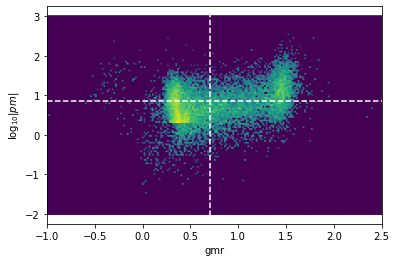

In [370]:
bright = rmag < 19
very_bright = rmag < 16
pl.hexbin(gmr[bright],np.log10(np.abs(pm[bright])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

#### Selection diagram: MWS mag range and good spectra

In [371]:
bright = rmag <= 19
specok = spec_ok(d.rv)
print(specok.sum(),len(d.rv), specok.sum()/len(d.rv))
print((bright & specok).sum(),len(d.rv), (bright & specok).sum()/len(d.rv))

250512 827395 0.3027719529366264
236899 827395 0.2863191099777011


In [372]:
pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

<ipython-input-372-a2dd8a284c74>:1: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)


<ipython-input-373-abf5c62edd64>:1: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok & ~is_std],np.log10(np.abs(pm[bright & specok & ~is_std])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)


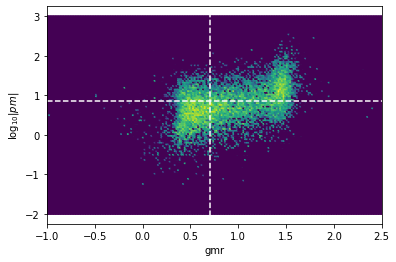

In [373]:
pl.hexbin(gmr[bright & specok & ~is_std],np.log10(np.abs(pm[bright & specok & ~is_std])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

#### Selection diagram: Standards

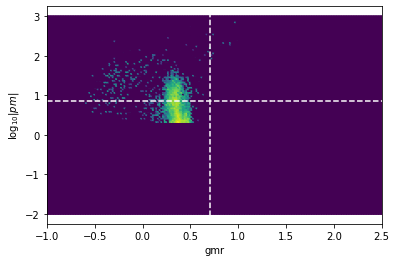

In [374]:
pl.hexbin(gmr[mws_stds],np.log10(np.abs(pm[mws_stds])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

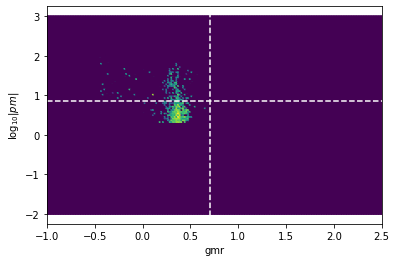

In [375]:
pl.hexbin(gmr[not_mws_stds],np.log10(np.abs(pm[not_mws_stds])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

#### Histograms

In [376]:
svmain = bright & specok & mws_sv_target & (~is_std)

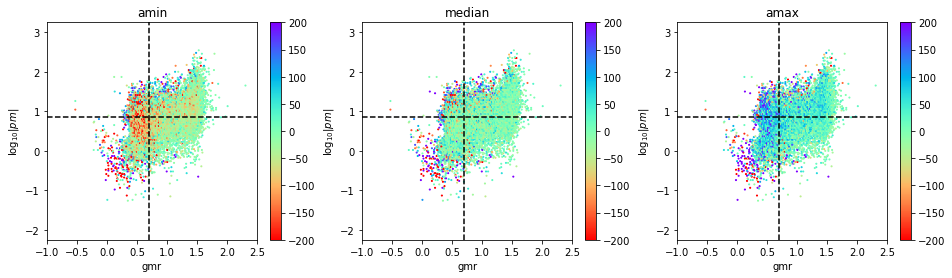

In [377]:
pl.figure(figsize=(16,4))
for i,func in enumerate([np.min,np.median,np.max]):
    pl.subplot(1,3,i+1)
    pl.hexbin(gmr[svmain],np.log10(np.maximum(0.001,np.abs(pm[svmain]))),
              C=d.rv['VRAD'][svmain],vmax=200,vmin=-200,
              reduce_C_function=func,cmap='rainbow_r',
              extent=(-1,2.5,-2,3),gridsize=200)
    pl.title(func.__name__)
    pl.xlim(-1,2.5)
    pl.xlabel('gmr')
    pl.ylabel('$\log_{10}|pm|$')
    pl.axvline(0.7,c='k',ls='--')
    pl.axhline(np.log10(7),c='k',ls='--')
    pl.colorbar()

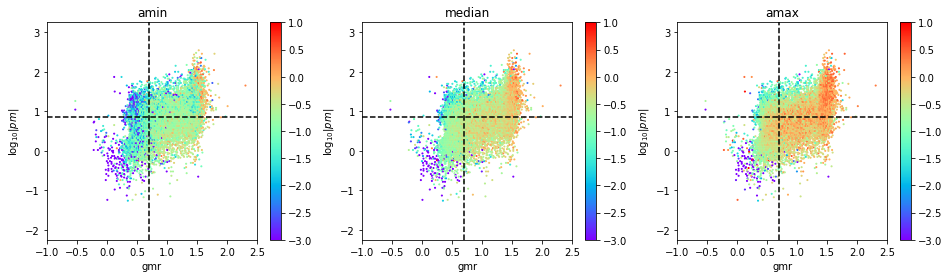

In [378]:
pl.figure(figsize=(16,4))
for i,func in enumerate([np.min,np.median,np.max]):
    pl.subplot(1,3,i+1)
    pl.hexbin(gmr[svmain],np.log10(np.maximum(0.001,np.abs(pm[svmain]))),
              C=d.rv['FEH'][svmain],vmax=1,vmin=-3,
              reduce_C_function=func,cmap='rainbow',
              extent=(-1,2.5,-2,3),gridsize=200)
    pl.title(func.__name__)
    pl.xlim(-1,2.5)
    pl.xlabel('gmr')
    pl.ylabel('$\log_{10}|pm|$')
    pl.axvline(0.7,c='k',ls='--')
    pl.axhline(np.log10(7),c='k',ls='--')
    pl.colorbar()

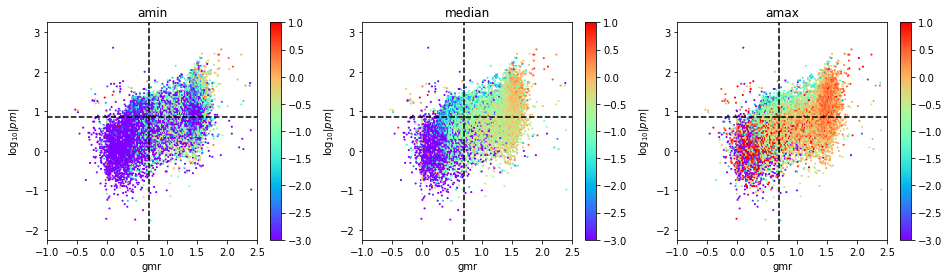

In [379]:
pl.figure(figsize=(16,4))
sel = ~svmain & ~is_std & ~specok
for i,func in enumerate([np.min,np.median,np.max]):
    pl.subplot(1,3,i+1)
    pl.hexbin(gmr[sel],np.log10(np.maximum(0.001,np.abs(pm[sel]))),
              C=d.rv['FEH'][sel],vmax=1,vmin=-3,
              reduce_C_function=func,cmap='rainbow',
              extent=(-1,2.5,-2,3),gridsize=200)
    pl.title(func.__name__)
    pl.xlim(-1,2.5)
    pl.xlabel('gmr')
    pl.ylabel('$\log_{10}|pm|$')
    pl.axvline(0.7,c='k',ls='--')
    pl.axhline(np.log10(7),c='k',ls='--')
    pl.colorbar()

In [380]:
pl.figure(figsize=(16,4))
for i,func in enumerate([np.min,np.median,np.max]):
    pl.subplot(1,3,i+1)
    pl.hexbin(gmr[svmain],np.log10(np.maximum(0.001,np.abs(pm[svmain]))),
              C=d.rv['LOGG'][svmain],vmax=6,vmin=0,
              reduce_C_function=func,cmap='viridis',
              extent=(-1,2.5,-2,3),gridsize=50)
    pl.title(func.__name__)
    pl.xlim(-1,2.5)
    pl.xlabel('gmr')
    pl.ylabel('$\log_{10}|pm|$')
    pl.axvline(0.7,c='k',ls='--')
    pl.axhline(np.log10(7),c='k',ls='--')
    pl.colorbar(label='logg')

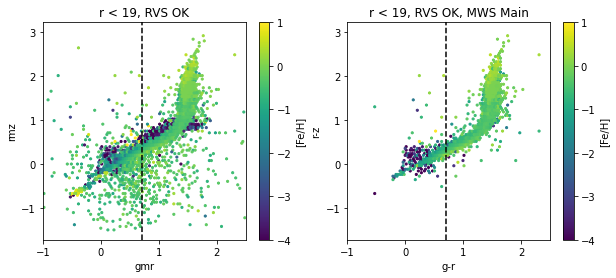

In [384]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.hexbin(gmr[bright & specok],rmz[bright & specok],
          C=d.rv['FEH'][bright & specok],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='[Fe/H]')
pl.title('r < 19, RVS OK')

pl.subplot(1,2,2)
pl.hexbin(gmr[svmain],rmz[svmain],
          C=d.rv['FEH'][svmain],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='[Fe/H]')
pl.title('r < 19, RVS OK, MWS Main');

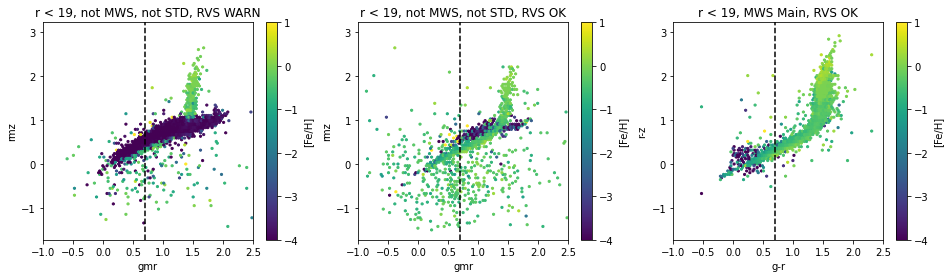

In [398]:
# Spectra that are not MWS targets
# Color is rvspecfit [Fe/H]

pl.figure(figsize=(16,4))

sel = (~mws_sv_target) & (~is_std) & (~specok) & bright  & ~very_bright
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          C=d.rv['FEH'][sel],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='[Fe/H]')
pl.title('r < 19, not MWS, not STD, RVS WARN')

sel = ~mws_sv_target & ~is_std & specok & bright  & ~very_bright
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          C=d.rv['FEH'][sel],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='[Fe/H]')
pl.title('r < 19, not MWS, not STD, RVS OK')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          C=d.rv['FEH'][svmain],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='[Fe/H]')
pl.title('r < 19, MWS Main, RVS OK');

In [396]:
# Spectra that are not MWS targets
# Color is rvspecfit chi^2 

pl.figure(figsize=(16,4))

sel = (~mws_sv_target) & (~is_std) & (~specok) & bright & (d['MORPHTYPE'] != 'PSF')  & ~very_bright
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          C=np.log10(d.rv['CHISQ_TOT'][sel]),
          reduce_C_function=np.median,
          vmin=3.5,vmax=4.5,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label=r'$\log_{10}\chi^{2}$')
pl.title('r < 19, not MWS, not STD, RVS WARN')

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] != 'PSF')  & ~very_bright
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          C=np.log10(d.rv['CHISQ_TOT'][sel]),
          reduce_C_function=np.median,
          vmin=3.5,vmax=4.5,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label=r'$\log_{10}\chi^{2}$')
pl.title('r < 19, not MWS, not STD, RVS OK')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          C=np.log10(d.rv['CHISQ_TOT'][svmain]),
          reduce_C_function=np.median,
          vmin=3.5,vmax=4.5,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label=r'$\log_{10}\chi^{2}$')
pl.title('r < 19, MWS Main, RVS OK');

In [400]:
# How many non-MWS targets with OK fits have type != PSF?
# Easiest to pick out for red r-z color...

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] != 'PSF')  & ~very_bright & (rmz > 1.1)
Table(np.unique(d['MORPHTYPE'][sel],return_counts=True))

<Table length=4>
MORPHTYPE  col1
  bytes4  int64
--------- -----
      DEV   102
      EXP    62
      REX    95
      SER    93

What fraction of these are really stars? Compare chi^2 distributions...

In [334]:
sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] != 'PSF')  & ~very_bright & (rmz < 1.1)
pl.plot(np.log10(np.sort(d.rv['CHISQ_TOT'][sel])),1-np.arange(0,sel.sum())/sel.sum(),c='b')

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] != 'PSF')  & ~very_bright & (rmz > 1.1)
pl.plot(np.log10(np.sort(d.rv['CHISQ_TOT'][sel])),1-np.arange(0,sel.sum())/sel.sum(),c='r')

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & (rmz < 1.1)
pl.plot(np.log10(np.sort(d.rv['CHISQ_TOT'][sel])),1-np.arange(0,sel.sum())/sel.sum(),c='b',ls='--')

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & (rmz > 1.1)
pl.plot(np.log10(np.sort(d.rv['CHISQ_TOT'][sel])),1-np.arange(0,sel.sum())/sel.sum(),c='r',ls='--')

pl.xlim(3.5,5.5)
pl.grid()

In [322]:
sel = mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & (rmz > 1.1)
Table(np.unique(d['MORPHTYPE'][sel],return_counts=True))

<Table length=1>
MORPHTYPE  col1
  bytes4  int64
--------- -----
      PSF 17039

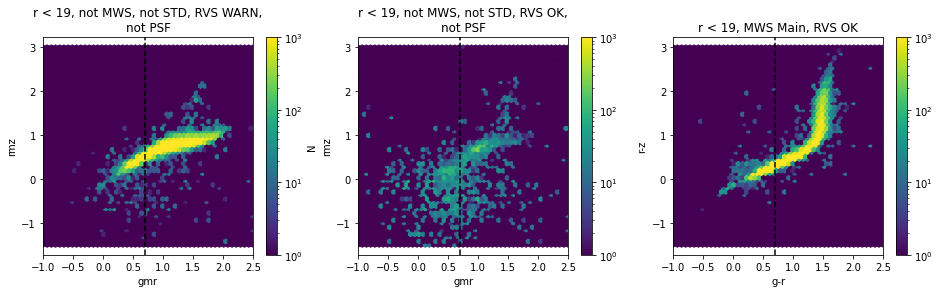

In [401]:
# Similar to previous plots but now look only at targets that are not PSF.

pl.figure(figsize=(16,4))

sel = (~mws_sv_target) & (~is_std) & (~specok) & bright & (d['MORPHTYPE'] != 'PSF')
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='N')
pl.title('r < 19, not MWS, not STD, RVS WARN,\nnot PSF')

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] != 'PSF')
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, not MWS, not STD, RVS OK,\nnot PSF')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, MWS Main, RVS OK');

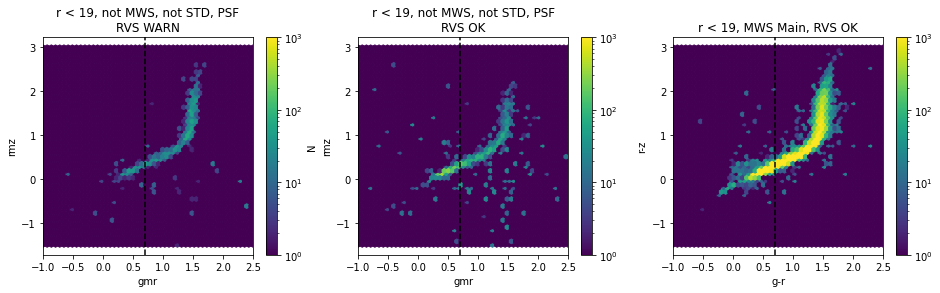

In [402]:
# Similar to previous plots but now look only at targets that *are* PSF.


pl.figure(figsize=(16,4))

# PSF in mag range but not a MW target, bad spectrum
sel = (~mws_sv_target) & (~is_std) & (~specok) & bright & (d['MORPHTYPE'] == 'PSF') & ~very_bright
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='N')
pl.title('r < 19, not MWS, not STD, PSF\nRVS WARN')

# PSF in mag range but not a MW target, good spectrum
sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, not MWS, not STD, PSF\nRVS OK')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, MWS Main, RVS OK');

Clear stellar locus in the middle plot above. What are the PSF sources that are not MWS targets?

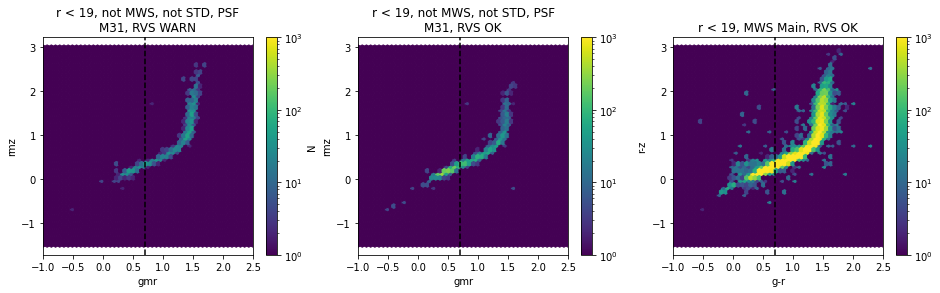

In [408]:
# Most of them are M31 targets.

pl.figure(figsize=(16,4))

# PSF in mag range but not a MW target, bad spectrum
sel = (~mws_sv_target) & (~is_std) & (~specok) & bright & (d['MORPHTYPE'] == 'PSF') & ~very_bright & m31_target
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='N')
pl.title('r < 19, not MWS, not STD, PSF\nM31, RVS WARN')

# PSF in mag range but not a MW target, good spectrum
sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & m31_target
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, not MWS, not STD, PSF\nM31, RVS OK')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, MWS Main, RVS OK');

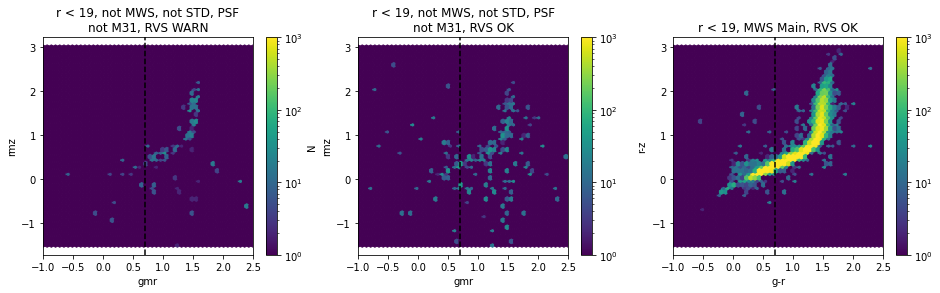

In [409]:
# The set that are not M31 targets

pl.figure(figsize=(16,4))

# PSF in mag range but not a MW target, bad spectrum
sel = (~mws_sv_target) & (~is_std) & (~specok) & bright & (d['MORPHTYPE'] == 'PSF') & ~very_bright & ~m31_target
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='N')
pl.title('r < 19, not MWS, not STD, PSF\nnot M31, RVS WARN')

# PSF in mag range but not a MW target, good spectrum
sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & ~m31_target
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, not MWS, not STD, PSF\nnot M31, RVS OK')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, MWS Main, RVS OK');

In [448]:
# They are mostly BGS_ANY

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & ~m31_target

print(sel.sum())

u,c = np.unique(d[sel]['SV1_DESI_TARGET'],return_counts=True)
Table(np.array([[','.join(desi_mask.names(a)),b] for a,b in zip(u,c)]))

2192


<Table length=19>
                                                            col0                                                            ...
                                                           str123                                                           ...
--------------------------------------------------------------------------------------------------------------------------- ...
                                                                          LRG,LRG_IR,LRG_SV_IR,LRG_IR_NORTH,LRG_SV_IR_NORTH ...
                                              LRG,LRG_IR,LRG_SV_OPT,LRG_SV_IR,LRG_IR_NORTH,LRG_SV_OPT_NORTH,LRG_SV_IR_NORTH ...
                                                                                  QSO,QSO_COLOR_8PASS,QSO_COLOR_8PASS_NORTH ...
                                                  QSO,QSO_COLOR_8PASS,QSO_RF_8PASS,QSO_COLOR_8PASS_NORTH,QSO_RF_8PASS_NORTH ...
                                      LRG,QSO,LRG_IR,LRG_SV_IR,QSO_RF_4PASS,LRG_IR_SOUTH,LRG_SV_IR_SOUTH,QSO_RF_4PASS_SOUTH ...
LRG,QSO,LRG_IR,LRG_SV_IR,QSO_COLOR_4PASS,QSO_RF_4PASS,LRG_IR_SOUTH,LRG_SV_IR_SOUTH,QSO_COLOR_4PASS_SOUTH,QSO_RF_4PASS_SOUTH ...
                                                                                  QSO,QSO_COLOR_8PASS,QSO_COLOR_8PASS_SOUTH ...
                                                  QSO,QSO_COLOR_8PASS,QSO_RF_8PASS,QSO_COLOR_8PASS_SOUTH,QSO_RF_8PASS_SOUTH ...
                                                                                                                    BGS_ANY ...
                                                                                    LRG,LRG_SV_OPT,LRG_SV_OPT_SOUTH,BGS_ANY ...
                                                                  LRG,LRG_IR,LRG_SV_IR,LRG_IR_SOUTH,LRG_SV_IR_SOUTH,BGS_ANY ...
                LRG,LRG_OPT,LRG_IR,LRG_SV_OPT,LRG_SV_IR,LRG_OPT_SOUTH,LRG_IR_SOUTH,LRG_SV_OPT_SOUTH,LRG_SV_IR_SOUTH,BGS_ANY ...
                                                                                QSO,QSO_RF_4PASS,QSO_RF_4PASS_NORTH,BGS_ANY ...
                                                                                QSO,QSO_RF_8PASS,QSO_RF_8PASS_NORTH,BGS_ANY ...
                                          QSO,QSO_COLOR_8PASS,QSO_RF_8PASS,QSO_COLOR_8PASS_NORTH,QSO_RF_8PASS_NORTH,BGS_ANY ...
                              LRG,QSO,LRG_IR,LRG_SV_IR,QSO_RF_4PASS,LRG_IR_SOUTH,LRG_SV_IR_SOUTH,QSO_RF_4PASS_SOUTH,BGS_ANY ...
                                                                          QSO,QSO_COLOR_8PASS,QSO_COLOR_8PASS_SOUTH,BGS_ANY ...
                                                                                QSO,QSO_RF_8PASS,QSO_RF_8PASS_SOUTH,BGS_ANY ...
                                          QSO,QSO_COLOR_8PASS,QSO_RF_8PASS,QSO_COLOR_8PASS_SOUTH,QSO_RF_8PASS_SOUTH,BGS_ANY ...

In [453]:
u,c = np.unique(d[sel & bgs]['SV1_BGS_TARGET'],return_counts=True)
Table(np.array([[','.join(bgs_mask.names(a)),b] for a,b in zip(u,c)]))

<Table length=6>
                        col0                         col1
                       str51                        str51
--------------------------------------------------- -----
                        BGS_BRIGHT,BGS_BRIGHT_NORTH   225
                            BGS_LOWQ,BGS_LOWQ_NORTH   328
BGS_BRIGHT,BGS_LOWQ,BGS_BRIGHT_NORTH,BGS_LOWQ_NORTH   792
                        BGS_BRIGHT,BGS_BRIGHT_SOUTH   237
                            BGS_LOWQ,BGS_LOWQ_SOUTH   208
BGS_BRIGHT,BGS_LOWQ,BGS_BRIGHT_SOUTH,BGS_LOWQ_SOUTH   320

In [508]:
# Create a table for unique targets in the selection above
nodups = Table.from_pandas(d[sel].to_pandas().drop_duplicates('TARGETID'))
nodups

<Table length=229>
     TARGETID     PETAL_LOC DEVICE_LOC ... FIBERFLUX_IVAR_Z HPXPIXEL
      int64         int16     int32    ...     float32       int64  
----------------- --------- ---------- ... ---------------- --------
39633143531045956         2        443 ...            1e+20   999999
39633152305529112         8        340 ...            1e+20   999999
39627652595714859         6        373 ...            1e+20   999999
39627598535333330         1        372 ...            1e+20   999999
39627706685465014         2        202 ...            1e+20   999999
39627706689659276         2        107 ...            1e+20   999999
39628133581722807         1        211 ...            1e+20   999999
39628133581718925         1        249 ...            1e+20   999999
39628127743246974         9        495 ...            1e+20   999999
39628168604160654         4         60 ...            1e+20   999999
              ...       ...        ... ...              ...      ...
39633057434567830         9        362 ...            1e+20   999999
39633076145359428         8        352 ...            1e+20   999999
39633071456128747         2        120 ...            1e+20   999999
39632989696561561         0         33 ...            1e+20   999999
39627781708975290         6         16 ...            1e+20   999999
39627799828368879         5        219 ...            1e+20   999999
39628121867032220         0        425 ...            1e+20   999999
39628174425856631         6        130 ...            1e+20   999999
39633442895299910         7         29 ...            1e+20   999999
39633227421320679         6        207 ...            1e+20   999999

In [509]:
_s = np.flatnonzero(d['TARGETID'] == nodups[2]['TARGETID'])
d[_s]

<Table length=1>
     TARGETID     PETAL_LOC DEVICE_LOC ... FIBERFLUX_IVAR_Z HPXPIXEL
      int64         int16     int32    ...     float32       int64  
----------------- --------- ---------- ... ---------------- --------
39627652595714859         6        373 ...            1e+20   999999

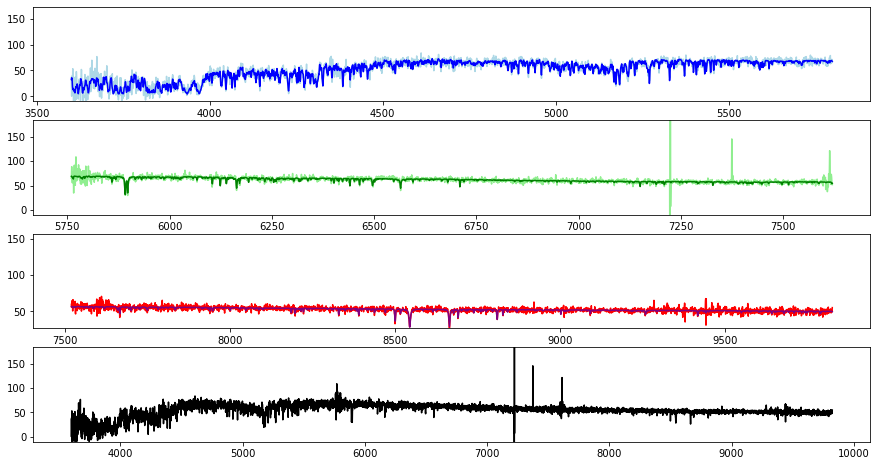

In [514]:
get_images(d[_s])
plot_targetid(d,d[_s]['TARGETID']);

In [516]:
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))

In [517]:
# This object doesn't have any REF_CAT or associated Gaia parameters, despite being in DR2 according to the viewer.
Table(targets[targets['TARGETID'] == d[_s]['TARGETID']])

<Table length=1>
RELEASE BRICKID BRICKNAME BRICK_OBJID ... PRIORITY_INIT NUMOBS_INIT HPXPIXEL
 int16   int32     str8      int32    ...     int64        int64     int64  
------- ------- --------- ----------- ... ------------- ----------- --------
   9010  298865  0365m055        2859 ...          2100           1    17683

In [523]:
_s = np.flatnonzero(d['TARGETID'] == nodups[3]['TARGETID'])
d[_s[0]]

<Row index=5237>
     TARGETID     PETAL_LOC DEVICE_LOC LOCATION FIBER FIBERSTATUS     TARGET_RA         TARGET_DEC       PMRA   PMDEC  REF_EPOCH LAMBDA_REF      FA_TARGET      FA_TYPE OBJTYPE FIBERASSIGN_X FIBERASSIGN_Y PRIORITY    SUBPRIORITY     OBSCONDITIONS RELEASE BRICKID BRICK_OBJID MORPHTYPE   FLUX_G   FLUX_R    FLUX_Z  FLUX_IVAR_G FLUX_IVAR_R FLUX_IVAR_Z REF_ID REF_CAT GAIA_PHOT_G_MEAN_MAG GAIA_PHOT_BP_MEAN_MAG GAIA_PHOT_RP_MEAN_MAG PARALLAX BRICKNAME     EBV      FLUX_W1  FLUX_W2  FLUX_IVAR_W1 FLUX_IVAR_W2 FIBERFLUX_G FIBERFLUX_R FIBERFLUX_Z FIBERTOTFLUX_G FIBERTOTFLUX_R FIBERTOTFLUX_Z MASKBITS  SERSIC SHAPE_R SHAPE_E1 SHAPE_E2 PHOTSYS PRIORITY_INIT NUMOBS_INIT   SV1_DESI_TARGET   SV1_BGS_TARGET SV1_MWS_TARGET DESI_TARGET BGS_TARGET MWS_TARGET NUM_ITER FIBER_X FIBER_Y  DELTA_X DELTA_Y      FIBER_RA          FIBER_DEC       NIGHT   EXPID      MJD      TILEID EXPTIME NUMTARGET CMX_TARGET BLOBDIST FIBERFLUX_IVAR_G FIBERFLUX_IVAR_R FIBERFLUX_IVAR_Z HPXPIXEL
      int64         int16     int32     int64   int32    int32         float64           float64       float32 float32  float32   float32          int64         uint8   bytes3    float32       float32     int32        float64           int32      int32   int32     int32      bytes4   float32  float32   float32    float32     float32     float32   int64   bytes2       float32               float32               float32        float32    bytes8    float32    float32  float32    float32      float32      float32     float32     float32      float32        float32        float32      int16   float32 float32 float32  float32   bytes1     int64        int64           int64            int64          int64         int64      int64      int64     int64   float64 float64  float64 float64      float64            float64        int32   int32    float64    int32  float64   int16     int64    float32      float32          float32          float32       int64  
----------------- --------- ---------- -------- ----- ----------- ----------------- ------------------ ------- ------- --------- ---------- ------------------- ------- ------- ------------- ------------- -------- ------------------ ------------- ------- ------- ----------- --------- --------- -------- --------- ----------- ----------- ----------- ------ ------- -------------------- --------------------- --------------------- -------- --------- ----------- --------- -------- ------------ ------------ ----------- ----------- ----------- -------------- -------------- -------------- -------- ------- ------- -------- -------- ------- ------------- ----------- ------------------- -------------- -------------- ----------- ---------- ---------- -------- ------- -------- ------- ------- ------------------ ------------------ -------- ----- ------------- ------ ------- --------- ---------- -------- ---------------- ---------------- ---------------- --------
39627598535333330         1        372     1372   961           0 34.94752998722026 -7.785782180727855     0.0     0.0 2021.0034     5400.0 1152921504606846976       1     TGT     260.91653    -196.38145     2000 0.8487821825932937             4    9010  285976        5586       PSF 19.582611 70.43961 133.24072   354.78427   120.02042    46.96984      0                          0.0                   0.0                   0.0      0.0  0349m077 0.021956777 81.890114 69.15231        1e+20        1e+20   15.251372    54.85994  103.770836        68.3579      225.35484      439.13205       16     0.0     0.0      0.0      0.0       S          2000           1 1152921504606846976         131074              0           0          0          0        2 260.845 -196.322   0.003  -0.007 34.947541012206806 -7.785755006271709 20210105 70931 59220.1616822  80635   1e+20     16959     999999    1e+20            1e+20            1e+20            1e+20   999999

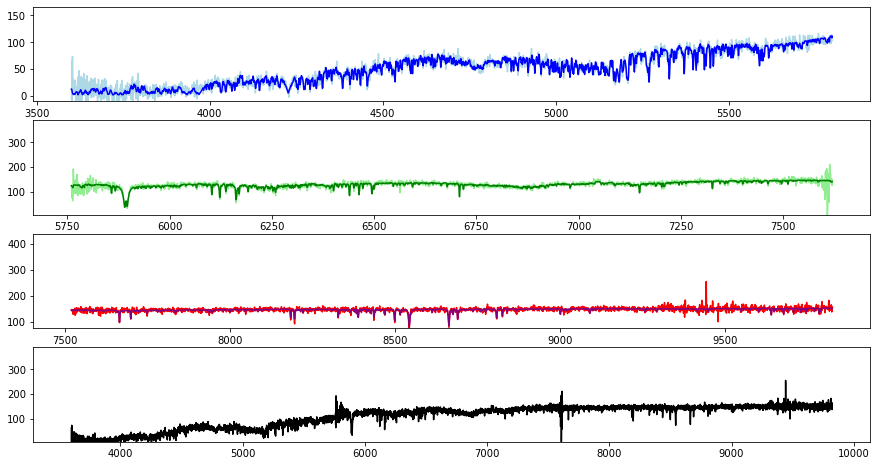

In [527]:
get_images([d[_s][0]])
plot_targetid(d,d[_s[0]]['TARGETID']);

In [ ]:
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))

In [530]:
# Similar story...
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))
Table(targets[targets['TARGETID'] == d[_s[0]]['TARGETID']])

<Table length=1>
RELEASE BRICKID BRICKNAME BRICK_OBJID ... PRIORITY_INIT NUMOBS_INIT HPXPIXEL
 int16   int32     str8      int32    ...     int64        int64     int64  
------- ------- --------- ----------- ... ------------- ----------- --------
   9010  285976  0349m077        5586 ...          2100           1    17668

In [533]:
# A large fraction are not in MWS because they are missing a ref cat
np.unique(d[sel]['REF_CAT'],return_counts=True)

(<Column name='REF_CAT' dtype='bytes2' length=2>
   
 G2,
 array([1613,  579]))

In [536]:
not_gaia = d['REF_CAT'] == ''

In [539]:
np.unique(d[sel & not_gaia]['TILEID'],return_counts=True)

(<Column name='TILEID' dtype='int32' length=35>
 80611
 80612
 80613
 80614
 80616
 80617
 80618
 80619
 80624
 80626
 80627
 80628
   ...
 80646
 80650
 80653
 80654
 80655
 80656
 80660
 80662
 80663
 80664
 80666
 80693,
 array([ 47,  29, 179,  44, 163, 116, 141,  38,  20,   5,  18,   2,   8,
          5,  30,   4,  16,  49, 112, 119,  70,  84,  16,  35, 106,  22,
          9,  71,  14,   9,   5,   9,   1,   9,   8]))

In [540]:
u,c = np.unique(d[sel & bgs & ~not_gaia]['SV1_BGS_TARGET'],return_counts=True)
Table(np.array([[','.join(bgs_mask.names(a)),b] for a,b in zip(u,c)]))

<Table length=6>
                        col0                         col1
                       str51                        str51
--------------------------------------------------- -----
                        BGS_BRIGHT,BGS_BRIGHT_NORTH     7
                            BGS_LOWQ,BGS_LOWQ_NORTH    30
BGS_BRIGHT,BGS_LOWQ,BGS_BRIGHT_NORTH,BGS_LOWQ_NORTH   419
                        BGS_BRIGHT,BGS_BRIGHT_SOUTH    26
                            BGS_LOWQ,BGS_LOWQ_SOUTH     3
BGS_BRIGHT,BGS_LOWQ,BGS_BRIGHT_SOUTH,BGS_LOWQ_SOUTH    12

In [550]:
# Create a table for unique targets in the selection above
nodups = Table.from_pandas(d[sel & bgs & ~not_gaia].to_pandas().drop_duplicates('TARGETID'))
nodups

<Table length=44>
     TARGETID     PETAL_LOC DEVICE_LOC ... FIBERFLUX_IVAR_Z HPXPIXEL
      int64         int16     int32    ...     float32       int64  
----------------- --------- ---------- ... ---------------- --------
39628133581722807         1        211 ...            1e+20   999999
39633345008634947         4        126 ...            1e+20   999999
39633341669967833         4         72 ...            1e+20   999999
39633321180792983         9        320 ...            1e+20   999999
39633152301334906         8        180 ...            1e+20   999999
39633152292950534         8        120 ...            1e+20   999999
39633139147998425         1        408 ...            1e+20   999999
39633147901514386         2        489 ...            1e+20   999999
39633173792949510         6        495 ...            1e+20   999999
39633160937408474         6         53 ...            1e+20   999999
              ...       ...        ... ...              ...      ...
39633565071181360         7        260 ...            1e+20   999999
39633047888331951         2         19 ...            1e+20   999999
39633043127798481         2        133 ...            1e+20   999999
39633062060886507         6        350 ...            1e+20   999999
39633255695125395         7          0 ...            1e+20   999999
39633240100702297         0        201 ...            1e+20   999999
39633085393800424         7        469 ...            1e+20   999999
39633057434567830         9        362 ...            1e+20   999999
39633076145359428         8        352 ...            1e+20   999999
39627781708975290         6         16 ...            1e+20   999999

In [554]:
_s = np.flatnonzero(d['TARGETID'] == nodups[2]['TARGETID'])
print(rmag[_s][0])
d[_s][0]

16.790474


<Row index=0>
     TARGETID     PETAL_LOC DEVICE_LOC LOCATION FIBER FIBERSTATUS     TARGET_RA          TARGET_DEC        PMRA      PMDEC    REF_EPOCH LAMBDA_REF      FA_TARGET      FA_TYPE OBJTYPE FIBERASSIGN_X FIBERASSIGN_Y PRIORITY    SUBPRIORITY     OBSCONDITIONS RELEASE BRICKID BRICK_OBJID MORPHTYPE   FLUX_G   FLUX_R    FLUX_Z   FLUX_IVAR_G FLUX_IVAR_R FLUX_IVAR_Z        REF_ID       REF_CAT GAIA_PHOT_G_MEAN_MAG GAIA_PHOT_BP_MEAN_MAG GAIA_PHOT_RP_MEAN_MAG  PARALLAX BRICKNAME    EBV      FLUX_W1  FLUX_W2  FLUX_IVAR_W1 FLUX_IVAR_W2 FIBERFLUX_G FIBERFLUX_R FIBERFLUX_Z FIBERTOTFLUX_G FIBERTOTFLUX_R FIBERTOTFLUX_Z MASKBITS  SERSIC SHAPE_R SHAPE_E1 SHAPE_E2 PHOTSYS PRIORITY_INIT NUMOBS_INIT   SV1_DESI_TARGET   SV1_BGS_TARGET SV1_MWS_TARGET DESI_TARGET BGS_TARGET MWS_TARGET NUM_ITER FIBER_X FIBER_Y DELTA_X DELTA_Y FIBER_RA FIBER_DEC  NIGHT   EXPID      MJD       TILEID EXPTIME NUMTARGET CMX_TARGET BLOBDIST FIBERFLUX_IVAR_G FIBERFLUX_IVAR_R FIBERFLUX_IVAR_Z HPXPIXEL
      int64         int16     int32     int64   int32    int32         float64            float64        float32    float32    float32   float32          int64         uint8   bytes3    float32       float32     int32        float64           int32      int32   int32     int32      bytes4   float32  float32   float32     float32     float32     float32          int64         bytes2       float32               float32               float32         float32    bytes8   float32    float32  float32    float32      float32      float32     float32     float32      float32        float32        float32      int16   float32 float32 float32  float32   bytes1     int64        int64           int64            int64          int64         int64      int64      int64     int64   float64 float64 float64 float64 float64   float64   int32   int32    float64     int32  float64   int16     int64    float32      float32          float32          float32       int64  
----------------- --------- ---------- -------- ----- ----------- ------------------ ----------------- ----------- ---------- --------- ---------- ------------------- ------- ------- ------------- ------------- -------- ------------------ ------------- ------- ------- ----------- --------- --------- -------- ---------- ----------- ----------- ----------- ------------------- ------- -------------------- --------------------- --------------------- --------- --------- ---------- --------- -------- ------------ ------------ ----------- ----------- ----------- -------------- -------------- -------------- -------- ------- ------- -------- -------- ------- ------------- ----------- ------------------- -------------- -------------- ----------- ---------- ---------- -------- ------- ------- ------- ------- -------- --------- -------- ----- -------------- ------ ------- --------- ---------- -------- ---------------- ---------------- ---------------- --------
39633341669967833         4         72     4072  2478           0 105.78825563772115 56.55033216216445 -0.23083869 0.45478973 2020.9624     5400.0 1152921504606846976       1     TGT     128.05347     111.65053     2000 0.9779846513727071             4    9011  606670        2009       PSF 69.225006 192.2254 125.025536    9.105178    4.625091  0.37820834 1000407392019986944      G2            17.812984                   nan                   nan 0.4482391  1057p565 0.05432146 51.980007 27.42295        1e+20        1e+20    53.90347   149.68024    97.35369       227.2062      318.85275       398.3571     2204     0.0     0.0      0.0      0.0       N          2000           1 1152921504606846976           2570              0           0          0          0        2  128.02 111.643   0.005     0.0      0.0       0.0 20201220 69042 59204.22354176  80613   1e+20     16959     999999    1e+20            1e+20            1e+20            1e+20   999999

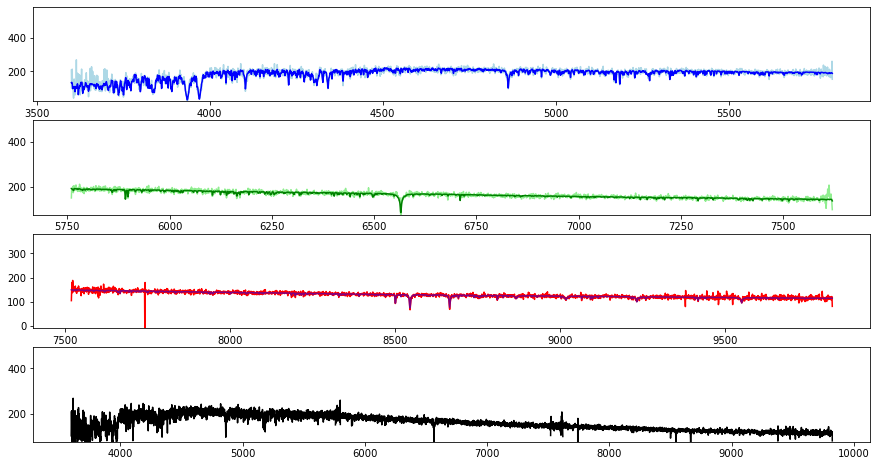

In [552]:
get_images([d[_s][0]])
plot_targetid(d,d[_s[0]]['TARGETID']);

In [556]:
# In this case large fracmasked
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))
Table(targets[targets['TARGETID'] == d[_s[0]]['TARGETID']])

<Table length=1>
RELEASE BRICKID BRICKNAME BRICK_OBJID ... PRIORITY_INIT NUMOBS_INIT HPXPIXEL
 int16   int32     str8      int32    ...     int64        int64     int64  
------- ------- --------- ----------- ... ------------- ----------- --------
   9011  606670  1057p565        2009 ...          2100           1     7108

In [558]:
_s = np.flatnonzero(d['TARGETID'] == nodups[0]['TARGETID'])
print(rmag[_s][0])
d[_s][0]

18.123848


<Row index=0>
     TARGETID     PETAL_LOC DEVICE_LOC LOCATION FIBER FIBERSTATUS     TARGET_RA         TARGET_DEC         PMRA      PMDEC    REF_EPOCH LAMBDA_REF      FA_TARGET      FA_TYPE OBJTYPE FIBERASSIGN_X FIBERASSIGN_Y PRIORITY    SUBPRIORITY     OBSCONDITIONS RELEASE BRICKID BRICK_OBJID MORPHTYPE  FLUX_G   FLUX_R   FLUX_Z  FLUX_IVAR_G FLUX_IVAR_R FLUX_IVAR_Z        REF_ID       REF_CAT GAIA_PHOT_G_MEAN_MAG GAIA_PHOT_BP_MEAN_MAG GAIA_PHOT_RP_MEAN_MAG  PARALLAX  BRICKNAME     EBV      FLUX_W1   FLUX_W2   FLUX_IVAR_W1 FLUX_IVAR_W2 FIBERFLUX_G FIBERFLUX_R FIBERFLUX_Z FIBERTOTFLUX_G FIBERTOTFLUX_R FIBERTOTFLUX_Z MASKBITS  SERSIC SHAPE_R SHAPE_E1 SHAPE_E2 PHOTSYS PRIORITY_INIT NUMOBS_INIT   SV1_DESI_TARGET   SV1_BGS_TARGET SV1_MWS_TARGET DESI_TARGET BGS_TARGET MWS_TARGET NUM_ITER FIBER_X FIBER_Y  DELTA_X DELTA_Y      FIBER_RA          FIBER_DEC      NIGHT   EXPID      MJD      TILEID EXPTIME NUMTARGET CMX_TARGET BLOBDIST FIBERFLUX_IVAR_G FIBERFLUX_IVAR_R FIBERFLUX_IVAR_Z HPXPIXEL
      int64         int16     int32     int64   int32    int32         float64           float64         float32    float32    float32   float32          int64         uint8   bytes3    float32       float32     int32        float64           int32      int32   int32     int32      bytes4  float32  float32  float32    float32     float32     float32          int64         bytes2       float32               float32               float32         float32     bytes8    float32    float32   float32     float32      float32      float32     float32     float32      float32        float32        float32      int16   float32 float32 float32  float32   bytes1     int64        int64           int64            int64          int64         int64      int64      int64     int64   float64 float64  float64 float64      float64            float64       int32   int32    float64    int32  float64   int16     int64    float32      float32          float32          float32       int64  
----------------- --------- ---------- -------- ----- ----------- ----------------- ------------------ ----------- ---------- --------- ---------- ------------------- ------- ------- ------------- ------------- -------- ------------------ ------------- ------- ------- ----------- --------- -------- -------- -------- ----------- ----------- ----------- ------------------- ------- -------------------- --------------------- --------------------- ---------- --------- ----------- --------- ---------- ------------ ------------ ----------- ----------- ----------- -------------- -------------- -------------- -------- ------- ------- -------- -------- ------- ------------- ----------- ------------------- -------------- -------------- ----------- ---------- ---------- -------- ------- -------- ------- ------- ------------------ ----------------- -------- ----- ------------- ------ ------- --------- ---------- -------- ---------------- ---------------- ---------------- --------
39628133581722807         1        211     1211   567           0 115.4838432749691 14.520848621323623 0.017145112 -0.1362495 2021.0034     5400.0 1152921504606846976       1     TGT     124.35461    -242.31035     2000 0.9844936265457489             4    9010  413541        5303       PSF 35.77424 56.29384 66.65471   420.34024    129.8352   84.224846 3164718137769975680      G2             18.73658             18.528803             17.571806 0.21562871  1154p145 0.046428047 17.036968 -1.1186745        1e+20        1e+20   27.808617    43.75925    51.81313      29.949644      47.943775        57.7012        0     0.0     0.0      0.0      0.0       S          2000           1 1152921504606846976         131074              0           0          0          0        2 124.323 -242.275  -0.002     0.0 115.48383500186803 14.52084870599824 20210106 71113 59221.3219787  80644   1e+20     16959     999999    1e+20            1e+20            1e+20            1e+20   999999

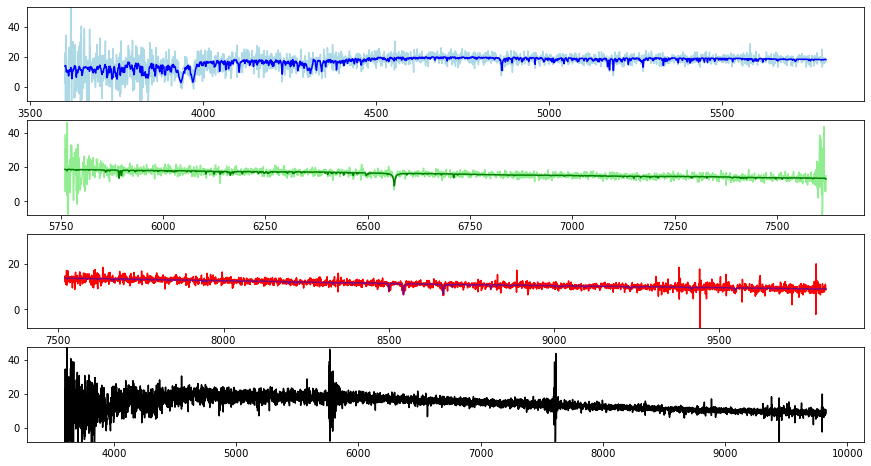

In [559]:
get_images([d[_s][0]])
plot_targetid(d,d[_s[0]]['TARGETID']);

In [561]:
# In this case Gaia duplicated source = True
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))
Table(targets[targets['TARGETID'] == d[_s[0]]['TARGETID']])

<Table length=1>
RELEASE BRICKID BRICKNAME BRICK_OBJID ... PRIORITY_INIT NUMOBS_INIT HPXPIXEL
 int16   int32     str8      int32    ...     int64        int64     int64  
------- ------- --------- ----------- ... ------------- ----------- --------
   9010  413541  1154p145        5303 ...          2100           1    22486

In [562]:
_s = np.flatnonzero(d['TARGETID'] == nodups[1]['TARGETID'])
print(rmag[_s][0])
d[_s][0]

16.097286


<Row index=0>
     TARGETID     PETAL_LOC DEVICE_LOC LOCATION FIBER FIBERSTATUS     TARGET_RA          TARGET_DEC       PMRA     PMDEC   REF_EPOCH LAMBDA_REF      FA_TARGET      FA_TYPE OBJTYPE FIBERASSIGN_X FIBERASSIGN_Y PRIORITY    SUBPRIORITY    OBSCONDITIONS RELEASE BRICKID BRICK_OBJID MORPHTYPE   FLUX_G    FLUX_R    FLUX_Z  FLUX_IVAR_G FLUX_IVAR_R FLUX_IVAR_Z        REF_ID       REF_CAT GAIA_PHOT_G_MEAN_MAG GAIA_PHOT_BP_MEAN_MAG GAIA_PHOT_RP_MEAN_MAG  PARALLAX  BRICKNAME     EBV      FLUX_W1  FLUX_W2  FLUX_IVAR_W1 FLUX_IVAR_W2 FIBERFLUX_G FIBERFLUX_R FIBERFLUX_Z FIBERTOTFLUX_G FIBERTOTFLUX_R FIBERTOTFLUX_Z MASKBITS  SERSIC SHAPE_R SHAPE_E1 SHAPE_E2 PHOTSYS PRIORITY_INIT NUMOBS_INIT   SV1_DESI_TARGET   SV1_BGS_TARGET SV1_MWS_TARGET DESI_TARGET BGS_TARGET MWS_TARGET NUM_ITER FIBER_X FIBER_Y DELTA_X DELTA_Y FIBER_RA FIBER_DEC  NIGHT   EXPID      MJD       TILEID EXPTIME NUMTARGET CMX_TARGET BLOBDIST FIBERFLUX_IVAR_G FIBERFLUX_IVAR_R FIBERFLUX_IVAR_Z HPXPIXEL
      int64         int16     int32     int64   int32    int32         float64            float64       float32   float32   float32   float32          int64         uint8   bytes3    float32       float32     int32        float64          int32      int32   int32     int32      bytes4   float32   float32   float32    float32     float32     float32          int64         bytes2       float32               float32               float32         float32     bytes8    float32    float32  float32    float32      float32      float32     float32     float32      float32        float32        float32      int16   float32 float32 float32  float32   bytes1     int64        int64           int64            int64          int64         int64      int64      int64     int64   float64 float64 float64 float64 float64   float64   int32   int32    float64     int32  float64   int16     int64    float32      float32          float32          float32       int64  
----------------- --------- ---------- -------- ----- ----------- ------------------ ----------------- --------- --------- --------- ---------- ------------------- ------- ------- ------------- ------------- -------- ----------------- ------------- ------- ------- ----------- --------- --------- --------- --------- ----------- ----------- ----------- ------------------- ------- -------------------- --------------------- --------------------- ---------- --------- ----------- --------- -------- ------------ ------------ ----------- ----------- ----------- -------------- -------------- -------------- -------- ------- ------- -------- -------- ------- ------------- ----------- ------------------- -------------- -------------- ----------- ---------- ---------- -------- ------- ------- ------- ------- -------- --------- -------- ----- -------------- ------ ------- --------- ---------- -------- ---------------- ---------------- ---------------- --------
39633345008634947         4        126     4126  2209           0 105.55008236782996 56.69544305503319 -9.052883 1.2864734 2020.9624     5400.0 1152921504606846976       1     TGT     160.26613     148.55647     2000 0.961585791637541             4    9011  607466        3139       PSF 188.23665 363.98636 310.91116   19.580086   4.1428905 0.115804024 1000412477261070976      G2            17.062557                   nan                   nan 0.61292505  1054p567 0.051316544 137.98683 70.37708        1e+20        1e+20   146.37268   283.03555    241.7643      146.38268       283.0468      241.78352     2204     0.0     0.0      0.0      0.0       N          2000           1 1152921504606846976           2570              0           0          0          0        2 160.222 148.555   0.007  -0.004      0.0       0.0 20201220 69042 59204.22354176  80613   1e+20     16959     999999    1e+20            1e+20            1e+20            1e+20   999999

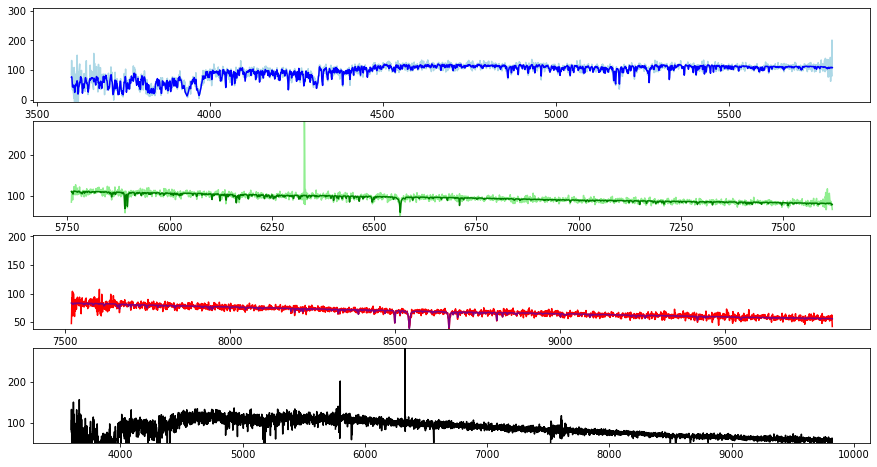

In [563]:
get_images([d[_s][0]])
plot_targetid(d,d[_s[0]]['TARGETID']);

In [565]:
# In this case large fracmasked
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))
Table(targets[targets['TARGETID'] == d[_s[0]]['TARGETID']])

<Table length=1>
RELEASE BRICKID BRICKNAME BRICK_OBJID ... PRIORITY_INIT NUMOBS_INIT HPXPIXEL
 int16   int32     str8      int32    ...     int64        int64     int64  
------- ------- --------- ----------- ... ------------- ----------- --------
   9011  607466  1054p567        3139 ...          2100           1     7108

In [569]:
targets['GAIA_DUPLICATED_SOURCE'].sum()

2277

In [593]:
fails_fracmasked = (targets['FRACMASKED_G'] > 0.5) | (targets['FRACMASKED_R'] > 0.5) 

In [594]:
len(targets)

388209

In [595]:
fails_fracmasked.sum()

4604

In [596]:
targets_gmag = 22.5-2.5*np.log10(targets['FLUX_G'])
targets_rmag = 22.5-2.5*np.log10(targets['FLUX_R'])
targets_rmag_ok = targets['FLUX_R'] > 0
targets_rnobs_ok = targets['NOBS_R'] > 0
targets_aen_ok = targets['GAIA_ASTROMETRIC_EXCESS_NOISE'] < 3
targets_psf = targets['MORPHTYPE'] == 'PSF'

<ipython-input-596-38b3448bd18f>:1: RuntimeWarning: divide by zero encountered in log10
  targets_gmag = 22.5-2.5*np.log10(targets['FLUX_G'])
<ipython-input-596-38b3448bd18f>:1: RuntimeWarning: invalid value encountered in log10
  targets_gmag = 22.5-2.5*np.log10(targets['FLUX_G'])
<ipython-input-596-38b3448bd18f>:2: RuntimeWarning: divide by zero encountered in log10
  targets_rmag = 22.5-2.5*np.log10(targets['FLUX_R'])


In [597]:
targets_in_mag_range = targets_psf & targets_rmag_ok & targets_rnobs_ok & (targets_rmag > 16) & (targets_rmag < 19)

In [598]:
targets_in_mag_range.sum(), (targets_in_mag_range & fails_fracmasked).sum()

(167011, 484)

In [604]:
Table(targets[targets_in_mag_range & fails_fracmasked])[0:10]['RA','DEC','GAIA_DUPLICATED_SOURCE','GAIA_ASTROMETRIC_EXCESS_NOISE']

<Table length=10>
        RA                DEC         ... GAIA_ASTROMETRIC_EXCESS_NOISE
     float64            float64       ...            float32           
------------------ ------------------ ... -----------------------------
104.64593948505835 54.707501020956855 ...                     2.6871734
104.47241643208902  54.76356971839178 ...                     0.6743169
104.65408716483466 54.903500182310395 ...                      0.955299
 103.8438419648123  55.45663560317964 ...                     1.8131357
  104.540895652981  55.86519453950276 ...                     1.0865474
103.92246833436971 55.948749468486184 ...                     0.8657632
102.67581275874326  55.48878203554542 ...                           0.0
102.14152381760985  55.95488595179229 ...                    0.04946962
102.02515442877478 56.047352185826966 ...                    0.23506317
 101.8841018994207 56.109168201706126 ...                    0.82091993

Text(0, 0.5, 'N(g-r)/mag')

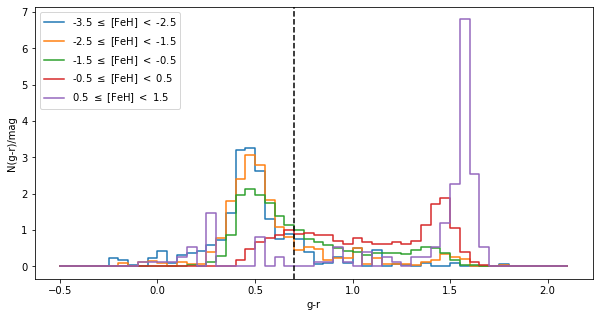

In [142]:
gmr_bins = np.arange(-0.5,2.2,0.05)
feh_bins = np.arange(-3.5,2.5,1)

pl.figure(figsize=(10,5))
for feh_l,feh_h in zip(feh_bins[:-1],feh_bins[1:]):
    sel = (feh_l <= d.rv['FEH']) &  (d.rv['FEH'] < feh_h)
    sel &= svmain
    h,b = np.histogram(gmr[sel],bins=gmr_bins,density=True)
    pl.plot(b[:-1],h,drawstyle='steps-post',label='{:3.1f} $\leq$ [FeH] $<$ {:3.1f}'.format(feh_l,feh_h))
pl.legend()
pl.axvline(0.7,c='k',ls='--')
pl.xlabel('g-r')
pl.ylabel('N(g-r)/mag')

Text(0.5, 0, 'g-r')

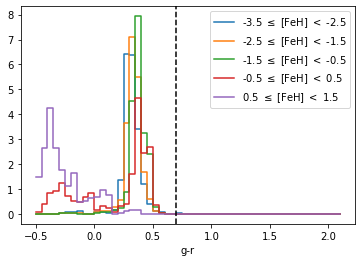

In [118]:
gmr_bins = np.arange(-0.5,2.2,0.05)
feh_bins = np.arange(-3.5,2.5,1)

for feh_l,feh_h in zip(feh_bins[:-1],feh_bins[1:]):
    sel = (feh_l <= d.rv['FEH']) &  (d.rv['FEH'] < feh_h)
    sel &= is_std & mws_sv_target & specok
    h,b = np.histogram(gmr[sel],bins=gmr_bins,density=True)
    pl.plot(b[:-1],h,drawstyle='steps-post',label='{:3.1f} $\leq$ [FeH] $<$ {:3.1f}'.format(feh_l,feh_h))
pl.legend()
pl.axvline(0.7,c='k',ls='--')
pl.xlabel('g-r')

In [261]:
is_mws_red,is_mws_blue,is_mws_broad = mws_samples(d)

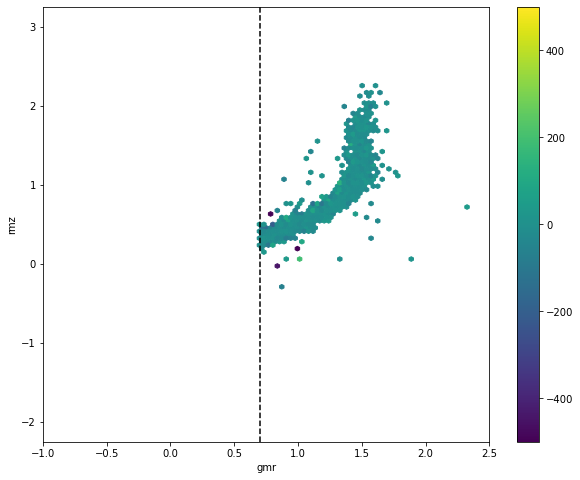

In [262]:
pl.figure(figsize=(10,8))
sel = bright & specok & mws_sv_target & is_mws_red
pl.hexbin(gmr[sel],rmz[sel],
          C=d.rv['VRAD'][sel],vmax=500,vmin=-500,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()

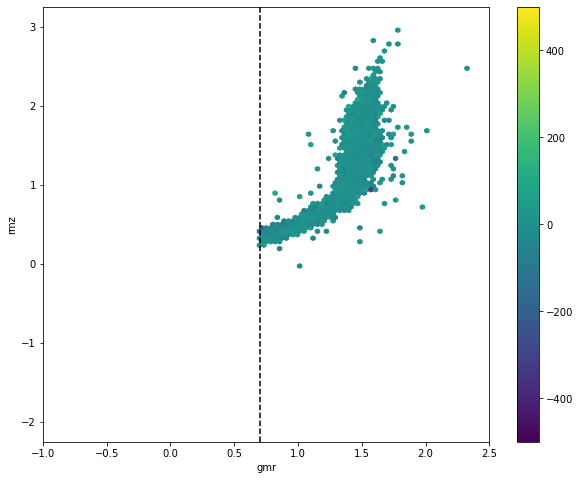

In [264]:
pl.figure(figsize=(10,8))
sel = bright & specok & mws_sv_target & is_mws_broad
pl.hexbin(gmr[sel],rmz[sel],
          C=d.rv['VRAD'][sel],vmax=500,vmin=-500,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()

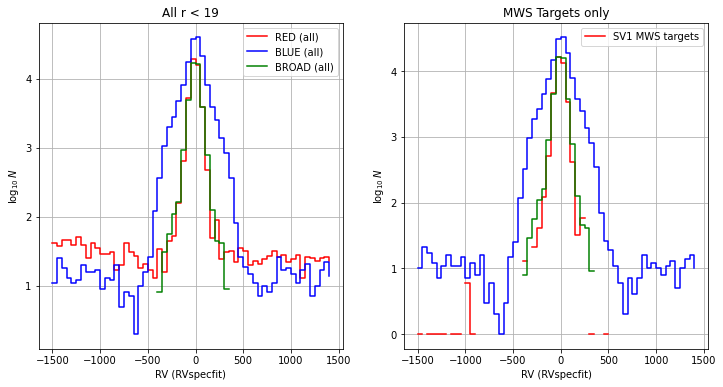

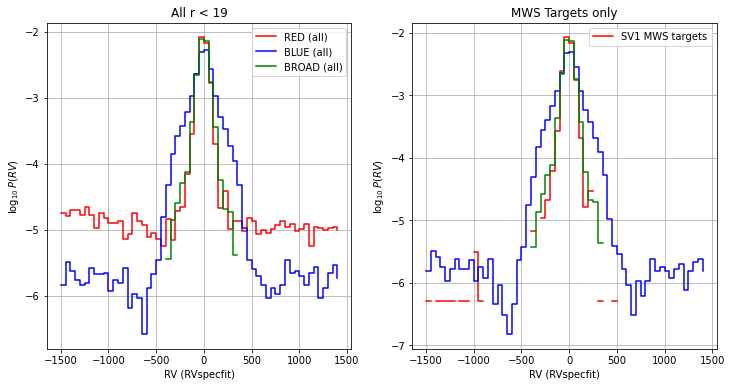

In [267]:
# Top: absolute; bottom: fraction

def decorate():
    pl.grid()
    pl.xlabel('RV (RVspecfit)')
    pl.ylabel('$\log_{10}\,N$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['VRAD'],d,np.arange(-1500,1500,50),decorate=decorate)

def decorate():
    pl.grid()
    pl.xlabel('RV (RVspecfit)')
    pl.ylabel('$\log_{10}\,P(RV)$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['VRAD'],d,np.arange(-1500,1500,50),decorate=decorate,density=True)

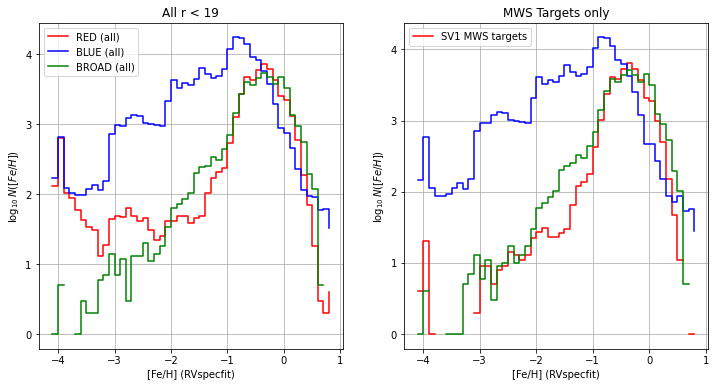

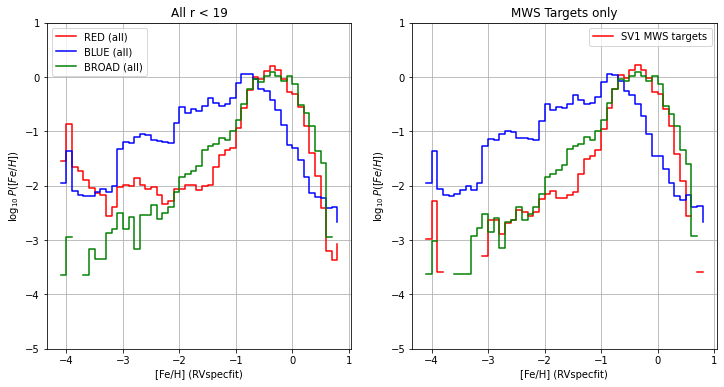

In [268]:
def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit)')
    pl.ylabel('$\log_{10}\,N([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),decorate=decorate,density=False)

def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit)')
    pl.ylabel('$\log_{10}\,P([Fe/H])$')
    pl.legend()
    pl.ylim(-5,1)
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),decorate=decorate,density=True)

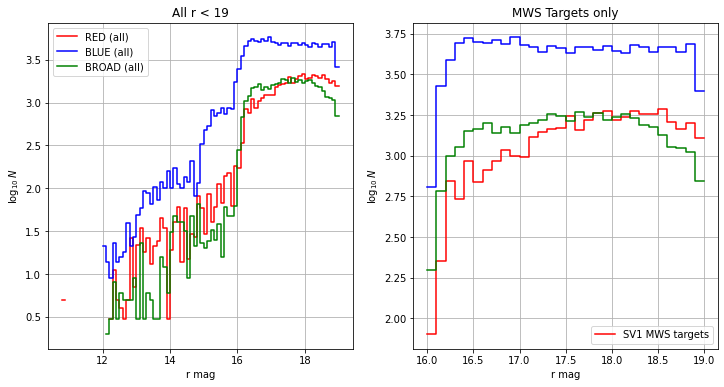

In [272]:
# r mag,absolute

def decorate():
    pl.grid()
    pl.xlabel('r mag')
    pl.ylabel('$\log_{10}\,N$')
    pl.legend()
    
plot_compare_mws_samples(rmag,d,np.arange(10,22,0.1),decorate=decorate)

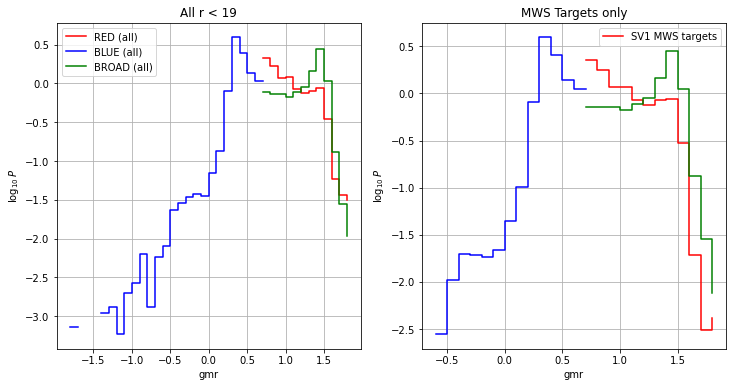

In [274]:
# g-r, probabilty

def decorate():
    pl.grid()
    pl.xlabel('gmr')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(gmr,d,np.arange(-2,2,0.1),decorate=decorate,density=True)

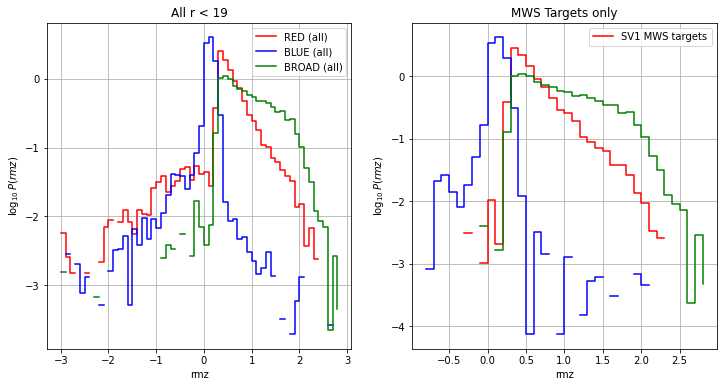

In [275]:
def decorate():
    pl.grid()
    pl.xlabel('rmz')
    pl.ylabel('$\log_{10}\,N$')
    pl.legend()
    
plot_compare_mws_samples(rmz,d,np.arange(-3,3,0.1),decorate=decorate,density=False)

def decorate():
    pl.grid()
    pl.xlabel('rmz')
    pl.ylabel('$\log_{10}\,P(rmz)$')
    pl.legend()
    
plot_compare_mws_samples(rmz,d,np.arange(-3,3,0.1),decorate=decorate,density=True)

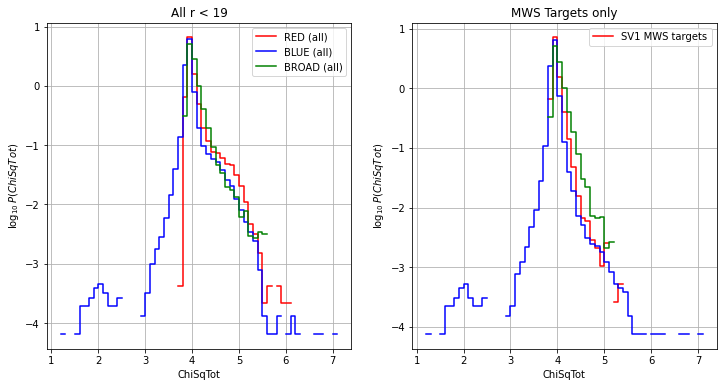

In [276]:
def decorate():
    pl.grid()
    pl.xlabel('ChiSqTot')
    pl.ylabel('$\log_{10}\,P(ChiSqTot)$')
    pl.legend()
plot_compare_mws_samples(np.log10(d.rv['CHISQ_TOT']),d,np.arange(1,10,0.1),decorate=decorate,density=True)

In [277]:
c = MWSCoadd(redux='blanc')
c

MWS: blanc-all (/global/cfs/cdirs/desi/science/mws/redux/blanc/mwtab_coadd-blanc-all.fits)

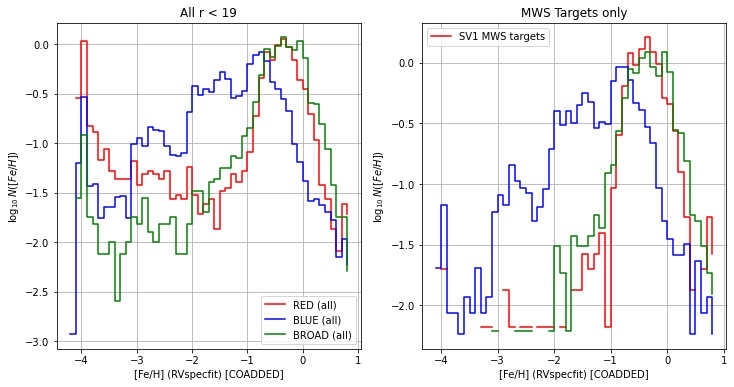

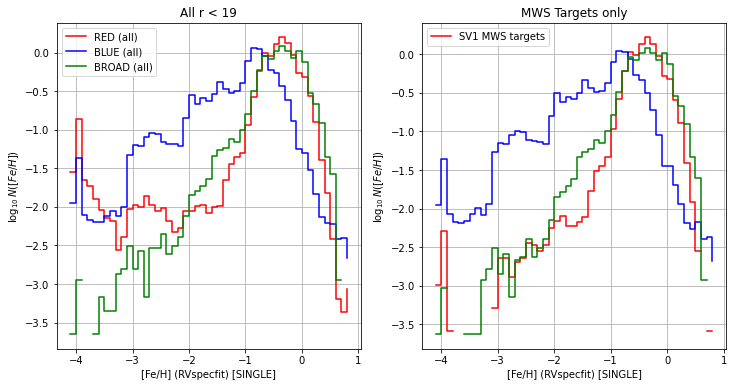

In [278]:
def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,N([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['FEH_RV'],c,np.arange(-5,1,0.1),
                         decorate=decorate,density=True,success='SUCCESS_RV')

def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,N([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),
                         decorate=decorate,density=True)

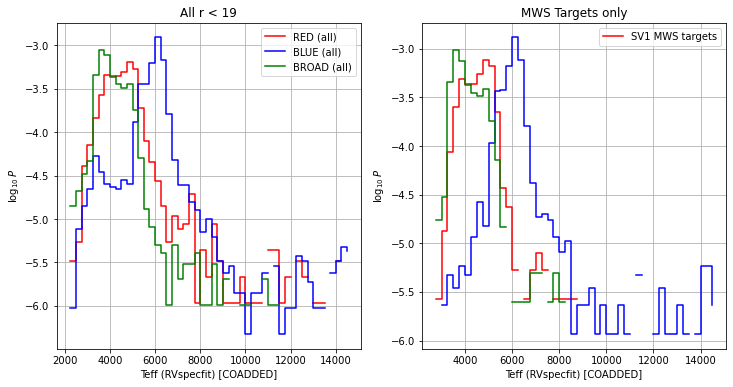

In [279]:
def decorate():
    pl.grid()
    pl.xlabel('Teff (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['TEFF_RV'],c,np.arange(0,15000,250),decorate=decorate,density=True,success='SUCCESS_RV')

def decorate():
    pl.grid()
    pl.xlabel('Teff (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['TEFF'],d,np.arange(0,15000,250),decorate=decorate,density=True)

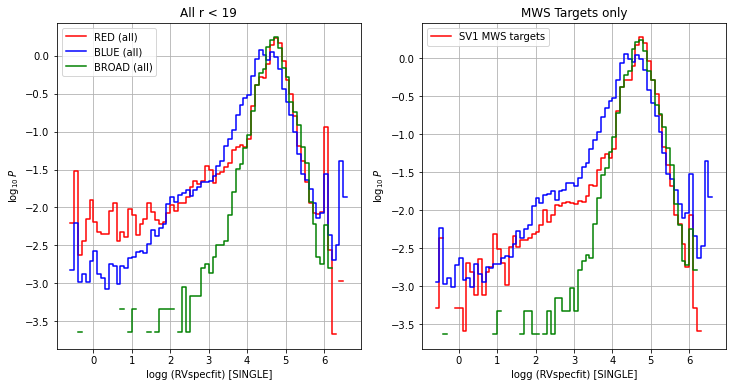

In [280]:
def decorate():
    pl.grid()
    pl.xlabel('logg (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['LOGG_RV'],c,np.arange(-1,7,0.1),decorate=decorate,density=True,success='SUCCESS_RV')

def decorate():
    pl.grid()
    pl.xlabel('logg (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['LOGG'],d,np.arange(-1,7,0.1),decorate=decorate,density=True)

(8.0, -1.0)

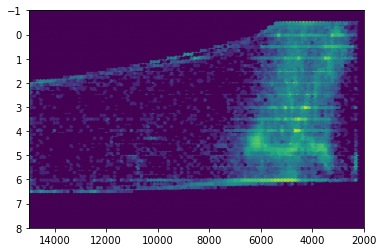

In [281]:
pl.hexbin(c.rv['TEFF_RV'],c.rv['LOGG_RV'],extent=(2000,15000,-1,8),bins='log')
pl.xlim(15000,2000)
pl.ylim(8,-1)

In [282]:
pl.hexbin(c.rv['TEFF_RV'][coadd_is_mws_target],c.rv['LOGG_RV'][coadd_is_mws_target],extent=(2000,15000,-1,8),bins='log')
pl.xlim(15000,2000)
pl.ylim(8,-1)

(8.0, -1.0)

In [283]:
pl.hexbin(c.rv['TEFF_RV'][coadd_is_mws_target],c.rv['LOGG_RV'][coadd_is_mws_target],
          C=c.rv['FEH_RV'][coadd_is_mws_target],reduce_C_function=np.median,
          extent=(2000,8000,1,6),gridsize=100)
pl.xlim(8000,2000)
pl.ylim(6,1)
pl.colorbar()

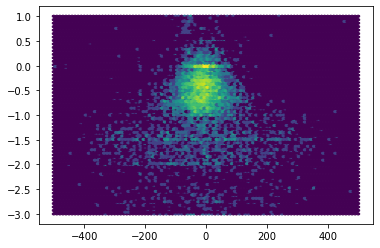

In [284]:
pl.hexbin(c.rv['VRAD'][coadd_is_mws_target],c.rv['FEH_RV'][coadd_is_mws_target],bins='log',extent=(-500,500,-3,1))

https://desi.lbl.gov/trac/wiki/SurveyValidation/SV1

https://desi.lbl.gov/trac/wiki/DESIOperations/ObservingPlans/OpsPlan20210101

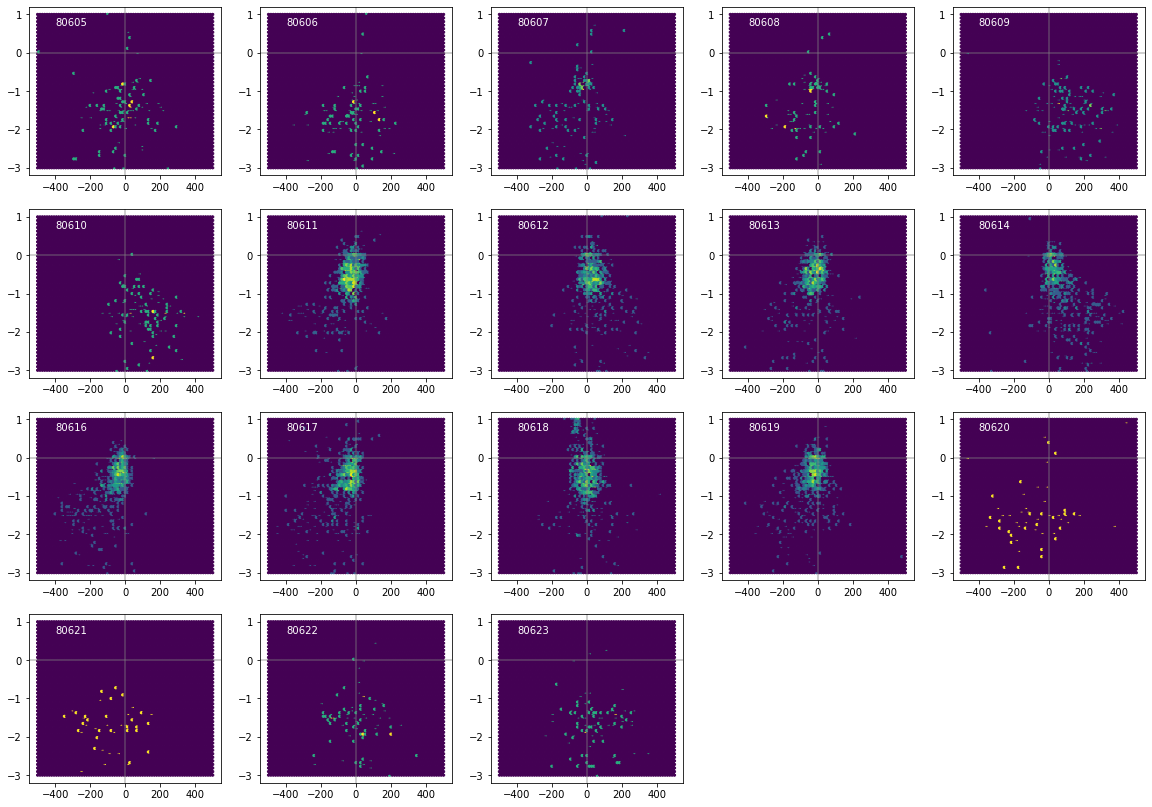

In [285]:
tileids = np.unique(c.fm['TILEID'][coadd_is_mws_target])
nplots = len(tileids)
nrow = int(np.ceil(np.sqrt(nplots)))

f = pl.figure(figsize=(20,18))

from matplotlib import gridspec
grid = gridspec.GridSpec(nrow,nrow)

for i,tileid in enumerate(tileids):
    f.add_subplot(grid[i])
    sel = (c.fm['TILEID'] == tileid) & coadd_is_mws_target
    pl.hexbin(c.rv['VRAD'][sel],
              c.rv['FEH_RV'][sel],
              gridsize=75,
              bins='log',extent=(-500,500,-3,1))
    pl.text(-400,0.7,tileid,fontsize=10,c='w')
    pl.axvline(0,c='grey',alpha=0.5)
    pl.axhline(0,c='grey',alpha=0.5)

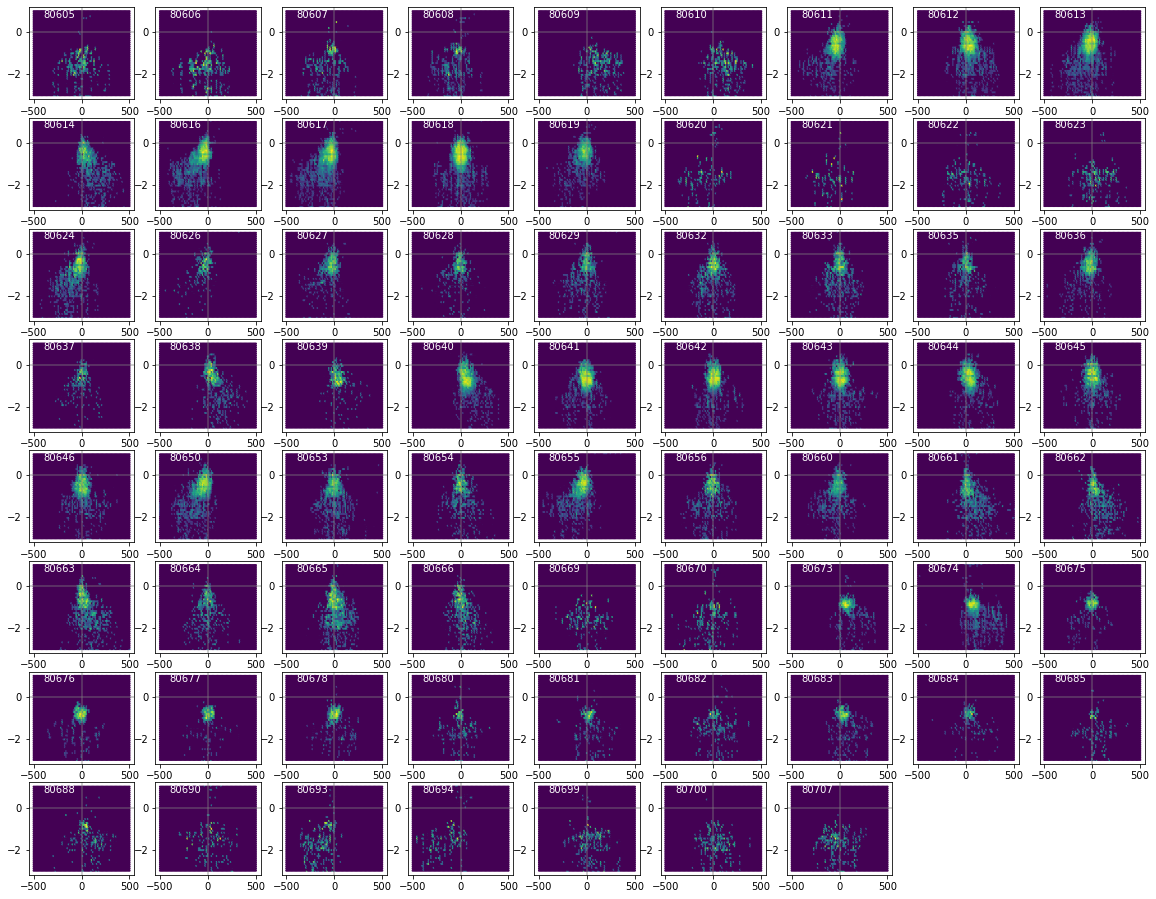

In [286]:
tileids = np.unique(d.fm['TILEID'][mws_sv_target & bright])
nplots = len(tileids)
nrow = int(np.ceil(np.sqrt(nplots)))

f = pl.figure(figsize=(20,18))

grid = gridspec.GridSpec(nrow,nrow)

for i,tileid in enumerate(tileids):
    f.add_subplot(grid[i])
    sel = (d.fm['TILEID'] == tileid) & mws_sv_target & bright & specok
    pl.hexbin(d.rv['VRAD'][sel],
              d.rv['FEH'][sel],
              gridsize=75,
              bins='log',extent=(-500,500,-3,1))
    pl.text(-400,0.7,tileid,fontsize=10,c='w')
    pl.axvline(0,c='grey',alpha=0.5)
    pl.axhline(0,c='grey',alpha=0.5)

In [343]:
theta, phi = np.radians(90-d['TARGET_DEC']), np.radians(d['TARGET_RA'])
ipix = hp.ang2pix(8,theta,phi,nest=True)

In [478]:
# UNIQUE IDS
# CONVOLVE WITH ERROR
# CMD

In [475]:
tileid = 80640
v = d['TILEID'] == tileid
hpix = np.unique(ipix[v])[0]
print(hpix)
idir = str(hpix)
if len(idir) < 3:
    idir = '0' 
else:
    idir = idir[0]
mock = fits.getdata('/project/projectdirs/desi/mocks/mws/galaxia/alpha/v0.0.6/healpix/8/{:s}/{:d}/mock_allsky_galaxia_desi-8-{:d}.fits'.format(idir,hpix,hpix))

m_vr = mock['TRUE_VHELIO']
m_feh = mock['TRUE_FEH']
s = (mock['TRUE_MAG_R_SDSS_NODUST'] < 19) & (mock['TRUE_MAG_R_SDSS_NODUST'] > 16)

f = pl.figure(figsize=(14,4))
f.add_subplot(131)
A = pl.hexbin(m_vr[s],
          m_feh[s],
          gridsize=75,
          bins='log',extent=(-500,500,-3,1))
pl.axvline(0,c='grey',alpha=0.5)
pl.axhline(0,c='grey',alpha=0.5)

f.add_subplot(132)
sel = (d.fm['TILEID'] == tileid) & specok & bright # & mws_sv_target & bright & specok
B = pl.hexbin(d.rv['VRAD'][sel],
          d.rv['FEH'][sel],
          gridsize=75,
          bins='log',extent=(-500,500,-3,1))
pl.text(-400,0.7,tileid,fontsize=10,c='w')
pl.axvline(0,c='grey',alpha=0.5)
pl.axhline(0,c='grey',alpha=0.5)

f.add_subplot(133)
ax = pl.gca()
h1,bx,by = np.histogram2d(m_vr,
                         m_feh,
                         bins=[50,50],
                         range=[[-500,500],[-3,1]],density=True)
h2,bx,by = np.histogram2d(d.rv['VRAD'][sel],
                          d.rv['FEH'][sel],
                         bins=[50,50],
                         range=[[-500,500],[-3,1]],density=True)
print(h.shape)
pl.imshow(((h2)-(h1)).T,origin='lower',cmap='seismic',extent=(-500,500,-3,1),aspect='auto',
          interpolation='nearest',vmin=-0.01,vmax=0.01)
pl.axvline(0,c='grey',alpha=0.5)
pl.axhline(0,c='grey',alpha=0.5)
pl.colorbar()

329
(100, 100)


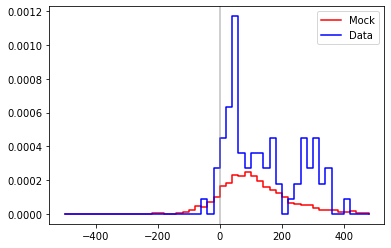

In [476]:
pl.plot(bx[:-1],h1[:,np.digitize(-1.5,by)],drawstyle='steps-post',c='r',label='Mock')
pl.plot(bx[:-1],h2[:,np.digitize(-1.5,by)],drawstyle='steps-post',c='b',label='Data')
pl.axvline(0,c='grey',alpha=0.5)
pl.legend()

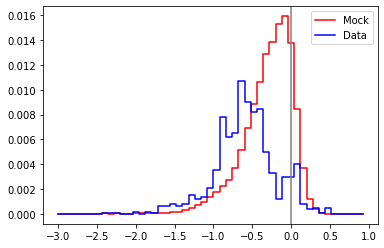

In [470]:
pl.plot(by[:-1],h1[np.digitize(0,bx),:],drawstyle='steps-post',c='r',label='Mock')
pl.plot(by[:-1],h2[np.digitize(0,bx),:],drawstyle='steps-post',c='b',label='Data')
pl.axvline(0,c='grey')
pl.legend()

In [474]:
mock['TRUE_MAG_R_SDSS_NODUST']

15.000156

In [287]:
n2419 = d['TILEID'] == 80618
c_n2419 = c['TILEID'] == 80618

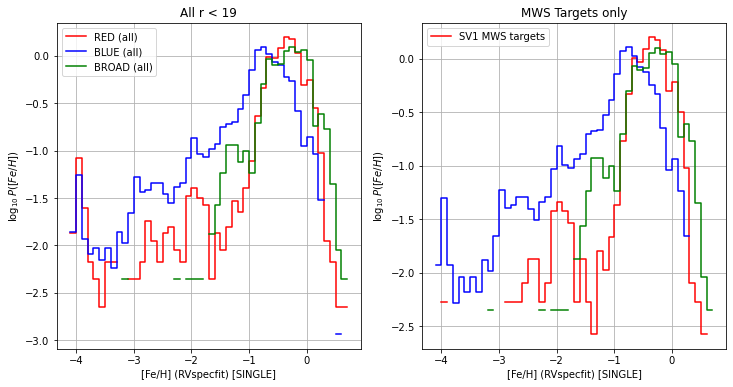

In [288]:
def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,P([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['FEH_RV'],c,np.arange(-5,1,0.1),decorate=decorate,density=True,success='SUCCESS_RV',sel=c_n2419)

def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,P([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),decorate=decorate,density=True,sel=n2419)

(19.5, 16.0)

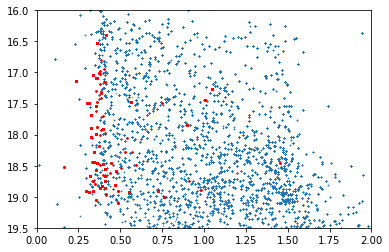

In [289]:
sel = n2419
lowz = n2419 & (d.rv['FEH'] < -2) & mws_sv_target & specok
pl.scatter(gmr[sel],rmag[sel],s=0.5,marker='.')
pl.scatter(gmr[lowz],rmag[lowz],s=10,marker='.',zorder=10,c='r')
pl.xlim(0,2)
pl.ylim(19.5,16)

(111.96393687072678, 116.44786821135334, 36.702204186764, 40.24271873704268)

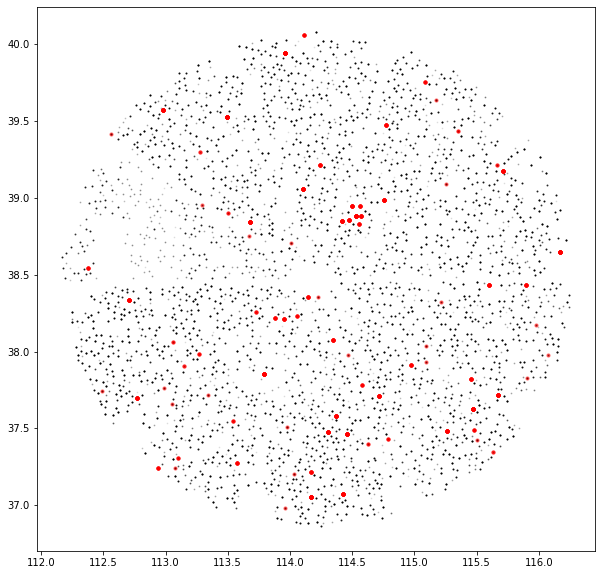

In [290]:
pl.figure(figsize=(10,10))
pl.scatter(d['TARGET_RA'][sel],d['TARGET_DEC'][sel],s=0.5,marker='o',alpha=0.1,c='k')
pl.scatter(d['TARGET_RA'][lowz],d['TARGET_DEC'][lowz],s=10,marker='o',zorder=10,alpha=0.5,c='r')
pl.axis('auto')

In [291]:
import matplotlib.gridspec as gridspec

In [292]:
coadd_is_mws_target = (c['SV1_MWS_TARGET'] > 0) & (c['SV1_MWS_TARGET'] != 999999)
sel = coadd_is_mws_target
Table(np.unique(c['TILEID'][sel],return_counts=True))

<Table length=18>
TILEID  col1
int32  int64
------ -----
 80605   169
 80606   109
 80607   178
 80608    97
 80609   172
 80610   115
 80611   776
 80612   746
 80613   783
 80614   711
 80616   743
 80617   902
 80618   851
 80619   862
 80620    82
 80621    46
 80622   138
 80623   100

In [293]:
Table(np.unique(d['TILEID'],return_counts=True))

<Table length=72>
TILEID  col1
int32  int64
------ -----
 80254  8173
 80605  9151
 80606  2021
 80607 13640
 80608  3650
 80609 11170
 80610  2223
 80611 21348
 80612 33181
 80613 41931
   ...   ...
 80683  3467
 80684  1907
 80685  1364
 80688  2927
 80690  2753
 80693  2542
 80694  4580
 80699  2337
 80700  5059
 80707  2234

In [294]:
radec = coords.SkyCoord(d['TARGET_RA'],d['TARGET_DEC'],frame='icrs',unit='deg')

In [295]:
gal = radec.transform_to('galactic')

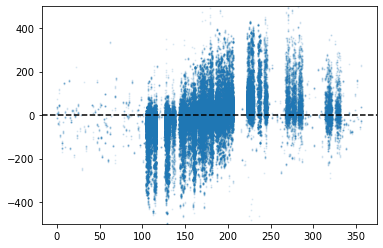

In [296]:
sel = mws_sv_target & bright & specok & (d.rv['RVS_WARN'] == 0)
pl.scatter(gal.l[sel],d.rv['VRAD'][sel],s=1,alpha=0.1)
pl.ylim(-500,500)
pl.axhline(0,c='k',ls='--')

In [297]:
(is_mws_red & specok).sum()

46804

In [298]:
(is_mws_broad & specok).sum()

44455

In [219]:
d['PARALLAX','PMRA','PMDEC']

<Table length=827395>
  PARALLAX      PMRA       PMDEC   
  float32     float32     float32  
----------- ----------- -----------
  0.2421939   1.1432372  -3.8170185
        0.0         0.0         0.0
 0.12624942  -0.3449254  -2.3723445
        0.0         0.0         0.0
        0.0         0.0         0.0
  0.7870298 -0.43930814 -0.11540886
-0.24068613  -2.0664961  -0.9580405
 0.11183568 -0.46135348   -2.931927
 0.03469967   6.7614417  -13.687192
 0.31000552  -1.8570336  -2.0993707
        ...         ...         ...
        0.0         0.0         0.0
        0.0         0.0         0.0
        0.0         0.0         0.0
        0.0         0.0         0.0
        0.0         0.0         0.0
        0.0         0.0         0.0
        0.0         0.0         0.0
0.043582965  -1.3813459  -1.4976779
-0.14174439   1.7213776  0.27915743
        0.0         0.0         0.0

In [224]:
c['PARALLAX','PMRA','GAIA_ASTROMETRIC_PARAMS_SOLVED']

<Table length=75010>
 PARALLAX      PMRA    GAIA_ASTROMETRIC_PARAMS_SOLVED
 float32     float32                bool             
---------- ----------- ------------------------------
 1.3864727  -0.7723985                           True
 1.0046731  -20.526825                           True
 0.5868535  -11.648711                           True
0.22243217  -10.532552                           True
 0.3468994  -11.568564                           True
 0.6195192 -15.4206085                           True
0.75662374  -13.848109                           True
 1.7476856    30.44077                           True
 2.0049965   1.9385488                           True
 0.9921698  -22.934172                           True
       ...         ...                            ...
       0.0         0.0                           True
       0.0         0.0                           True
       0.0         0.0                           True
       0.0         0.0                           True
       0.0         0.0                           True
       0.0         0.0                           True
       0.0         0.0                           True
0.29882634  0.32858732                           True
0.40069225  -2.6060402                           True
       0.0         0.0                           True

In [299]:
c.fm

<Table length=75010>
     TARGETID     PETAL_LOC DEVICE_LOC ... SV1_BGS_TARGET SV1_MWS_TARGET
      int64         int16     int32    ...     int64          int64     
----------------- --------- ---------- ... -------------- --------------
35186148770843363         0        525 ...         999999         999999
35186148770843761         0        509 ...         999999         999999
35186148770844616         0        493 ...         999999         999999
35186148775036873         0        503 ...         999999         999999
35186148775037106         0        505 ...         999999         999999
35186148775037985         0        490 ...         999999         999999
35186148775038800         0        471 ...         999999         999999
35186148775038953         0        449 ...         999999         999999
35186148779231024         0        484 ...         999999         999999
35186148779231600         0        465 ...         999999         999999
              ...       ...        ... ...            ...            ...
39628521873609111         9         44 ...              0              0
39628521877800059         9         59 ...              0              0
39628521877800693         9         41 ...              0              0
39628521877802345         9         39 ...              0              0
39628521877802902         9         46 ...              0              0
39628521881994212         9         92 ...              0              0
39628526999048802         9         15 ...              0              0
39628527003239026         9         18 ...              0             33
39628527003240941         9         21 ...              0              0
39628527003241360         9         26 ...              0              0